In [1]:
from gerrychain import Graph, Partition, GeographicPartition
from gerrychain.updaters import Tally, county_splits, boundary_nodes, cut_edges, cut_edges_by_part, exterior_boundaries, interior_boundaries, perimeter
import os

from custom_chain import CustomMarkovChain
from gerrychain.constraints import single_flip_contiguous, no_worse_L1_reciprocal_polsby_popper, districts_within_tolerance
from gerrychain.proposals import propose_random_flip
from gerrychain.accept import always_accept
import gerrychain.scores
from gerrychain import Election
from gerrychain.constraints.validity import deviation_from_ideal

import matplotlib.pyplot as plt

from collections import Counter
import numpy as np
import random

import time

In [2]:
def generate_graph(path):
    return Graph.from_file(path)
graph = generate_graph('PA_VTD.shp')

C:\Users\m\Anaconda3\envs\am207\lib\site-packages\gerrychain\graph\graph.py:193: UserWarning: Found leaves (degree-1 nodes, a.k.a. donuts). Indices of donuts: {1441, 1411, 2788, 2984, 169, 3792, 759, 1273, 63}
  donuts


In [17]:
def run_simple(graph, steps=1000):
    election = Election(
        "2016 President",
        {"Democratic": "T16PRESD", "Republican": "T16PRESR"},
        alias="2016_President"
    )
    
    
    p2 = Partition(
       graph,
       assignment="2011_PLA_1",
       updaters={
           "2016_President": election,
           "population": Tally("TOT_POP", alias="population"), 
           "black_population": Tally("BLACK_POP", alias = "black_population"),
           #"county_split" : county_splits( 'HI', "COUNTYFP10"),
                           "perimeter": perimeter,
               "exterior_boundaries": exterior_boundaries,
               "interior_boundaries": interior_boundaries,
               "boundary_nodes": boundary_nodes,
               "cut_edges": cut_edges,
               "area": Tally("area", alias="area"),
               "cut_edges_by_part": cut_edges_by_part

       }
   )


    efficiency_gaps = []
    wins = []
    
#     chain = MarkovChain(
#         proposal=propose_random_flip,
#         is_valid=single_flip_contiguous,
#         accept=metro_scoring_prob, #THe acceptance criteria is what needs to be defined ourselves - to match the paper
#         initial_state=p2,
#         total_steps=steps
#     )
    chain = CustomMarkovChain(
        proposal=propose_random_flip,
        is_valid=single_flip_contiguous,
        constraints=check_constraints,
        accept=metro_scoring_prob, #THe acceptance criteria is what needs to be defined ourselves - to match the paper
        initial_state=p2,
        total_steps=steps
    )
    
    
    #return chain
    for partition in chain:
        efficiency_gaps.append(gerrychain.scores.efficiency_gap(partition["2016_President"]))
        wins.append(partition["2016_President"].wins("Democratic"))
    return efficiency_gaps, wins
    
    
   

def metro_scoring_prob(partition, beta=0, wp=3000, wi=2.5, wc=0.4, wm=800):
    if(partition.parent == None):
        return True
    conflictedp = len(partition['cut_edges'])
    conflicted = conflictedp
    conflicted = len(partition.parent['cut_edges'])
    ratio = conflicted/conflictedp
    curr_score = score_partition(partition, wp, wi, wc, wm)
    prev_score = score_partition(partition.parent, wp, wi, wc, wm)
    exp = np.exp(-beta * (curr_score - prev_score))
    prob = min(1, ratio * exp)
    
#     return False
    
#     if check_constraints(partition):
#         print('accept')
    return(prob > random.random())
#     else:
#         #print('reject')
#         return False
#         #return 0.
    

def check_constraints(partition):
    #print(len(partition.parts))
    #print([districts_within_tolerance_check(partition), isoparametric_score_check(partition), minority_per_check(partition)])
    #raise ValueError
    return all([districts_within_tolerance_check(partition), isoparametric_score_check(partition), minority_per_check(partition)])

def districts_within_tolerance_check(partition, tol=1.01):
    populations = []
    for part in partition.parts:
        populations.append(partition['population'][part])
    populations = np.array(populations)
    if np.max(populations) > tol*np.mean(populations):
        return False
    return True



def isoparametric_score_check(partition, min_score=293):
    #scores = []
    for part in partition.parts:
        area, perimeter = partition['area'][part], partition['perimeter'][part]
        #print(isoparametric(area, perimeter))
        if isoparametric(area, perimeter) >= min_score:      
            #print(isoparametric(area, perimeter))
            return False
    return True
    
def minority_per_check(partition, min_rank2 = 0.335, min_rank1 = 0.4):
    per_minority = []
    for part in partition.parts:
        per_minority.append(partition['black_population'][part]/partition['population'][part])
    top2_per = sorted(per_minority)[-2:]
    if top2_per[1] > min_rank1 and top2_per[0] > min_rank2:
        return True
    else:
        return False
        
        
    fractions = Counter({k : black_pop_dict[k] / total_dict[k] for k in total_dict})
    
# def score_partition(partition, wp, wi, wc, wm):
#     return(equal_split_score(partition) * wp + compactness_split_score(partition) * wi+ 
#            county_split_wrapper(partition) * wc + vra_district_requirement(partition) * wm)

def score_partition(partition, wp, wi, wc, wm):
    return(equal_split_score(partition) * wp + compactness_split_score(partition) * wi + vra_district_requirement(partition) * wm)

def vra_district_requirement(partition, num_districts = 2, thresholds = [0.445, 0.36]):
    if(len(thresholds) != num_districts):
        raise Exception("Number of thresholds needs to equal the number of districts you want")
    black_pop_dict = partition['black_population']
    total_dict = partition['population']
    fractions = Counter({k : black_pop_dict[k] / total_dict[k] for k in total_dict})
    #print(fractions)
    top_n = fractions.most_common(num_districts)
    thresholds.sort()
    #print(top_n)
    score = 0
    for i in range(0, num_districts):
        #Get the max thresholds
        temp_score = max(0, thresholds[i] - top_n[i][1])
        score += np.sqrt(temp_score)
    return(score)
    
    
    
    
def isoparametric(area, perimeter):
    try:
        return (perimeter**2)/area
    except ZeroDivisionError:
        return np.nan

def polsby_popper(area, perimeter):
    try:
        return 4*np.pi*area / perimeter**2
    except ZeroDivisionError:
        return np.nan

def compact_dispersion(area, perimeter):
    raise NotImplementedError

def compactness_split_score(partition):
    isoparametric_parts = []
    #polsby_popper_parts = []
    #dispersion_parts = []
    for part in partition.parts:
        area, perimeter = partition['area'][part], partition['perimeter'][part]
        isoparametric_parts.append(isoparametric(area, perimeter))
        #polsby_popper_parts.append(polsby_popper(area, perimeter))
        #dispersion_parts.append()
    return np.sum(np.array(isoparametric_parts))
    #return np.array(polsby_popper_parts)
    #return np.array(dispersion_parts)

def equal_split_score(partition, population_name = 'population'):
    '''Take a partition and compute the root mean square deviance from a perfect equal split'''
    deviations = deviation_from_ideal(partition, population_name)
    score = np.linalg.norm(list(deviations.values()))
    return(score)
    
    
def county_split_wrapper(partition, county_split_name = 'county_split', district_name = '2011_PLA_1'):
    splits = county_split_score(partition, county_split_name)
    score = compute_countySplitWeight(partition, splits, county_split_name, district_name)
    return(score)
    
def county_split_score(partition, county_split_name = 'county_split'):
    splits = partition[county_split_name]
    to_check = {}
    for s in splits:
        num_split = len(splits[s][2])
        if(num_split > 1):
            prev = to_check.get(num_split, [])
            prev.append(s)
            to_check[num_split] = prev
    return(to_check)

def compute_countySplitWeight(partition, info, county_split_name = 'county_split', district_name = "2011_PLA_1"):
    '''Compute the county score function as described by the paper
    Takes in a parition with a county score_split data and computes the final 
    score'''
    two_counties = info[2]
    two_county_weight_sum = 0
    '''FIxme - should really combine both parts'''
    for c in two_counties:        
        nodes = partition[county_split_name][c][1]
        counties = [partition.graph.nodes[n][district_name] for n in nodes]
        cn = Counter(counties)
        second_frac = cn.most_common(2)[1][1]/ sum(cn.values())
        two_county_weight_sum += np.sqrt(second_frac)
    
    three_plus_weight_sum = 0
    for count_counties in range(3, len(info) +1):
        counties_split_list = info[count_counties]
        for c in counties_split_list:
            nodes = partition[county_split_name][c][1]
            counties = [partition.graph.nodes[n][district_name] for n in nodes]
            cn = Counter(counties)
            temp_frac = 0
            lst = cn.most_common()
            for i in range(2, len(lst)):
                temp_frac += lst[i][1]
            temp_frac = temp_frac / sum(cn.values())
            three_plus_weight_sum += np.sqrt(temp_frac)
    
    # Comput the 2 county split weight vs the 3 
    num_2 = len(two_counties)
    flat_list = [item for sublist in list(info.values()) for item in sublist]
    num_3plus = len(flat_list) - num_2
    final_score = two_county_weight_sum * num_2 + num_3plus * three_plus_weight_sum * 1000
    if(final_score < 0):
        raise Exception("FInal weight should be less than 0")
    return(final_score)

current conversion rate: 0.0005993407252022775
current conversion rate: 0.0008987417615338526
current conversion rate: 0.0011979634621144056
current conversion rate: 0.0014970059880239522
current conversion rate: 0.0017953321364452424
current conversion rate: 0.0020939276099311995
current conversion rate: 0.002391629297458894
current conversion rate: 0.0026873693639892504
current conversion rate: 0.0029850746268656717
current conversion rate: 0.003282602208296031
current conversion rate: 0.003579952267303103
current conversion rate: 0.0038771249627199524
current conversion rate: 0.004172876304023845
current conversion rate: 0.004469606674612634
current conversion rate: 0.004766160262138814
current conversion rate: 0.005062537224538415
current conversion rate: 0.005358737719559393
current conversion rate: 0.005649717514124294
current conversion rate: 0.005943536404160475
current conversion rate: 0.006238859180035651
current conversion rate: 0.006534006534006534
current conversion rate: 

current conversion rate: 0.056946354883081154
current conversion rate: 0.05720572057205721
current conversion rate: 0.0574649436348639
current conversion rate: 0.057708161582852434
current conversion rate: 0.05795111233177699
current conversion rate: 0.05819379632171287
current conversion rate: 0.05845225027442371
current conversion rate: 0.05867836578009323
current conversion rate: 0.05892025212386955
current conversion rate: 0.05917808219178082
current conversion rate: 0.059435771021637905
current conversion rate: 0.05962800875273523
current conversion rate: 0.05986878075451066
current conversion rate: 0.06012571740912818
current conversion rate: 0.060366020213056544
current conversion rate: 0.06062261059530311
current conversion rate: 0.06087906087906088
current conversion rate: 0.06111869031377899
current conversion rate: 0.06137479541734861
current conversion rate: 0.061613958560523444
current conversion rate: 0.061869719269555735
current conversion rate: 0.06210841732497957
curre

current conversion rate: 0.11475814412635735
current conversion rate: 0.1149765605724155
current conversion rate: 0.11516646115906289
current conversion rate: 0.11538461538461539
current conversion rate: 0.11560266206556569
current conversion rate: 0.11582060128141942
current conversion rate: 0.11600985221674877
current conversion rate: 0.116227530164984
current conversion rate: 0.11644510093549976
current conversion rate: 0.11666256460743293
current conversion rate: 0.11687992125984252
current conversion rate: 0.11706837186424005
current conversion rate: 0.11728546840422917
current conversion rate: 0.11750245821042281
current conversion rate: 0.11771934136151388
current conversion rate: 0.11790714812085483
current conversion rate: 0.1181237721021611
current conversion rate: 0.11834028971274245
current conversion rate: 0.11852760736196319
current conversion rate: 0.11874386653581943
current conversion rate: 0.11896001962227128
current conversion rate: 0.11917606669936243
current conver

current conversion rate: 0.14905272768774253
current conversion rate: 0.14924691921497032
current conversion rate: 0.14940693430656934
current conversion rate: 0.14960091220068414
current conversion rate: 0.14976065648506953
current conversion rate: 0.14992025518341306
current conversion rate: 0.15007970849464813
current conversion rate: 0.15017064846416384
current conversion rate: 0.15036396724294812
current conversion rate: 0.15055719808960655
current conversion rate: 0.1506818181818182
current conversion rate: 0.15080626845332729
current conversion rate: 0.15099909173478657
current conversion rate: 0.15115751248297776
current conversion rate: 0.15135012480145224
current conversion rate: 0.15150827852120663
current conversion rate: 0.15170068027210884
current conversion rate: 0.15189299478576287
current conversion rate: 0.1519818799546999
current conversion rate: 0.15213946117274169
current conversion rate: 0.15233137166138525
current conversion rate: 0.15252319529305272
current conv

current conversion rate: 0.1982741320489665
current conversion rate: 0.19843499197431783
current conversion rate: 0.19859578736208625
current conversion rate: 0.19875651825110308
current conversion rate: 0.19891718468016845
current conversion rate: 0.19907778668805132
current conversion rate: 0.19923832431348967
current conversion rate: 0.19939879759519039
current conversion rate: 0.1995592065718293
current conversion rate: 0.1997195512820513
current conversion rate: 0.19987983176447024
current conversion rate: 0.2000400480576692
current conversion rate: 0.2002002002002002
current conversion rate: 0.20036028823058447
current conversion rate: 0.2005203121873124
current conversion rate: 0.20068027210884354
current conversion rate: 0.20071971211515394
current conversion rate: 0.20083932853717026
current conversion rate: 0.200999000999001
current conversion rate: 0.20115860966839794
current conversion rate: 0.201318154583583
current conversion rate: 0.2014776357827476
current conversion ra

current conversion rate: 0.23790541764812467
current conversion rate: 0.238000362253215
current conversion rate: 0.23813835566823616
current conversion rate: 0.23823316437364228
current conversion rate: 0.2383710407239819
current conversion rate: 0.23850886717336228
current conversion rate: 0.23864664374886918
current conversion rate: 0.23878437047756873
current conversion rate: 0.23883565358886277
current conversion rate: 0.23893005602747153
current conversion rate: 0.23906758221900976
current conversion rate: 0.23920505871725384
current conversion rate: 0.23929925952681957
current conversion rate: 0.23939339230908105
current conversion rate: 0.2395306859205776
current conversion rate: 0.23962468422952002
current conversion rate: 0.23976186180768536
current conversion rate: 0.23981247746123333
current conversion rate: 0.239949522264287
current conversion rate: 0.24004325103622273
current conversion rate: 0.24018018018018017
current conversion rate: 0.24031705998919115
current conversi

current conversion rate: 0.26900778532383635
current conversion rate: 0.2691288506127857
current conversion rate: 0.2691607349776527
current conversion rate: 0.26928169480304537
current conversion rate: 0.26940261459539966
current conversion rate: 0.2694789081885856
current conversion rate: 0.269599735362223
current conversion rate: 0.2697205225731768
current conversion rate: 0.2698412698412698
current conversion rate: 0.26964993394980186
current conversion rate: 0.269770513455506
current conversion rate: 0.2698465093249711
current conversion rate: 0.26996699669966995
current conversion rate: 0.2700428901352689
current conversion rate: 0.2701632855022266
current conversion rate: 0.27023907666941466
current conversion rate: 0.27031481786715017
current conversion rate: 0.2703905091448344
current conversion rate: 0.27051070840197694
current conversion rate: 0.2705862977602108
current conversion rate: 0.27070640540095503
current conversion rate: 0.2708264734935792
current conversion rate: 

current conversion rate: 0.288340666247643
current conversion rate: 0.2884071630537229
current conversion rate: 0.28851892571069576
current conversion rate: 0.28863065326633164
current conversion rate: 0.2886517030293517
current conversion rate: 0.28876333961079725
current conversion rate: 0.2888296203326012
current conversion rate: 0.28894117647058826
current conversion rate: 0.28905269761606023
current conversion rate: 0.2891641837854791
current conversion rate: 0.28923028687882113
current conversion rate: 0.28934169278996863
current conversion rate: 0.2894530637831061
current conversion rate: 0.28951903493655023
current conversion rate: 0.28958496476115897
current conversion rate: 0.289650853295757
current conversion rate: 0.2897620538509706
current conversion rate: 0.28982785602503913
current conversion rate: 0.28993897668596463
current conversion rate: 0.2900500625782228
current conversion rate: 0.2901611137181292
current conversion rate: 0.2902721301219894
current conversion rate

current conversion rate: 0.31095406360424027
current conversion rate: 0.3110554983070808
current conversion rate: 0.31115690314983807
current conversion rate: 0.31125827814569534
current conversion rate: 0.3113596233078281
current conversion rate: 0.31146093864940416
current conversion rate: 0.3115622241835834
current conversion rate: 0.3115718276724011
current conversion rate: 0.31162722328384534
current conversion rate: 0.3117283950617284
current conversion rate: 0.31178372024684103
current conversion rate: 0.3118848244454238
current conversion rate: 0.3119858989424207
current conversion rate: 0.3120869437509179
current conversion rate: 0.31218795888399414
current conversion rate: 0.3122889443547203
current conversion rate: 0.3123899001761597
current conversion rate: 0.3124449662459642
current conversion rate: 0.31254585473220836
current conversion rate: 0.3126467136150235
current conversion rate: 0.3127475429074373
current conversion rate: 0.3128024637043555
current conversion rate:

current conversion rate: 0.3257166597424179
current conversion rate: 0.32571982281284606
current conversion rate: 0.3256779192030991
current conversion rate: 0.32577119933600773
current conversion rate: 0.32581938874291244
current conversion rate: 0.325912610619469
current conversion rate: 0.32600580671920365
current conversion rate: 0.3260989770528062
current conversion rate: 0.3261921216309606
current conversion rate: 0.32628524046434493
current conversion rate: 0.32637833356363133
current conversion rate: 0.32647140093948607
current conversion rate: 0.3265193370165746
current conversion rate: 0.32661234636099984
current conversion rate: 0.32670533001933166
current conversion rate: 0.326798288002209
current conversion rate: 0.32680099365166987
current conversion rate: 0.3268938871257072
current conversion rate: 0.3269867549668874
current conversion rate: 0.32707959718581875
current conversion rate: 0.32717241379310347
current conversion rate: 0.32722007722007723
current conversion ra

current conversion rate: 0.3467008327994875
current conversion rate: 0.3467401050339439
current conversion rate: 0.3467793571520041
current conversion rate: 0.3468629961587708
current conversion rate: 0.34694661374984
current conversion rate: 0.3469857929092538
current conversion rate: 0.347069362682365
current conversion rate: 0.3471529110684581
current conversion rate: 0.3471920173979788
current conversion rate: 0.3471423091676256
current conversion rate: 0.34718138821424005
current conversion rate: 0.34722044728434504
current conversion rate: 0.3473038589317659
current conversion rate: 0.34738724926536346
current conversion rate: 0.3474262357900115
current conversion rate: 0.3475095785440613
current conversion rate: 0.34759290001276977
current conversion rate: 0.34763181411974975
current conversion rate: 0.3477150880776104
current conversion rate: 0.34775395610005105
current conversion rate: 0.3478371825953809
current conversion rate: 0.3479203878540444
current conversion rate: 0.34

current conversion rate: 0.35864570737605805
current conversion rate: 0.35872324990932175
current conversion rate: 0.35880077369439073
current conversion rate: 0.3588349045201837
current conversion rate: 0.35886901884968586
current conversion rate: 0.3589031166948538
current conversion rate: 0.35893719806763286
current conversion rate: 0.3587979724837075
current conversion rate: 0.35874547647768396
current conversion rate: 0.35877954655089245
current conversion rate: 0.35881360019291053
current conversion rate: 0.35889089813140446
current conversion rate: 0.35892491261901893
current conversion rate: 0.35891566265060243
current conversion rate: 0.3589928924225997
current conversion rate: 0.3590701035894965
current conversion rate: 0.35914729615801516
current conversion rate: 0.35922447013487474
current conversion rate: 0.35930162552679107
current conversion rate: 0.3593787623404768
current conversion rate: 0.35945588058264116
current conversion rate: 0.35948970995306295
current conversi

current conversion rate: 0.37425786938501177
current conversion rate: 0.3743279569892473
current conversion rate: 0.37439802889461304
current conversion rate: 0.37442615608554475
current conversion rate: 0.37428667338032895
current conversion rate: 0.37431480031323416
current conversion rate: 0.3743010512189667
current conversion rate: 0.3743710164374371
current conversion rate: 0.3743991056456121
current conversion rate: 0.37442718229574157
current conversion rate: 0.3742879481737965
current conversion rate: 0.37427422956677087
current conversion rate: 0.37434408842246286
current conversion rate: 0.3744139316811788
current conversion rate: 0.3741913896944011
current conversion rate: 0.37421944692239073
current conversion rate: 0.37428921841899876
current conversion rate: 0.3742755238519839
current conversion rate: 0.37430354357031426
current conversion rate: 0.3743732590529248
current conversion rate: 0.3743595455558031
current conversion rate: 0.3744292237442922
current conversion ra

current conversion rate: 0.38322594274849475
current conversion rate: 0.38321013727560715
current conversion rate: 0.3832752613240418
current conversion rate: 0.3833403716216216
current conversion rate: 0.3834054681727014
current conversion rate: 0.38347055098163396
current conversion rate: 0.38349514563106796
current conversion rate: 0.38351972990082295
current conversion rate: 0.38358476632556177
current conversion rate: 0.3836497890295359
current conversion rate: 0.3836338711378256
current conversion rate: 0.38365840801265155
current conversion rate: 0.38352123063955323
current conversion rate: 0.3835861778339654
current conversion rate: 0.3836107014956815
current conversion rate: 0.3836756187467088
current conversion rate: 0.38374052232518957
current conversion rate: 0.3838054122354428
current conversion rate: 0.3838702884817856
current conversion rate: 0.38393515106853354
current conversion rate: 0.384
current conversion rate: 0.3840648352804968
current conversion rate: 0.38404882

current conversion rate: 0.3946344868854094
current conversion rate: 0.39469485440765856
current conversion rate: 0.3947552098913152
current conversion rate: 0.3947761937992224
current conversion rate: 0.3948365231259968
current conversion rate: 0.39489684042659223
current conversion rate: 0.39495714570460433
current conversion rate: 0.3950174389636273
current conversion rate: 0.3950777202072539
current conversion rate: 0.3951379894390754
current conversion rate: 0.3950801712976795
current conversion rate: 0.3951404102768373
current conversion rate: 0.3950826199482381
current conversion rate: 0.3951428287050861
current conversion rate: 0.395203025477707
current conversion rate: 0.3952632102696786
current conversion rate: 0.3953233830845771
current conversion rate: 0.3953835439259775
current conversion rate: 0.3953650288442411
current conversion rate: 0.3954251616111387
current conversion rate: 0.39548528241845665
current conversion rate: 0.3955060648240207
current conversion rate: 0.39

current conversion rate: 0.4053345811885821
current conversion rate: 0.40539023020774845
current conversion rate: 0.40544586881257605
current conversion rate: 0.4054635606698475
current conversion rate: 0.4053295932678822
current conversion rate: 0.4053851907255049
current conversion rate: 0.40540287904281175
current conversion rate: 0.4054584540611272
current conversion rate: 0.4054761237267545
current conversion rate: 0.4054937867887508
current conversion rate: 0.4055114432508174
current conversion rate: 0.40552909311665264
current conversion rate: 0.40550887021475257
current conversion rate: 0.4055643730744095
current conversion rate: 0.4056198655713219
current conversion rate: 0.4056374836662311
current conversion rate: 0.4056929538030798
current conversion rate: 0.40571055332649064
current conversion rate: 0.40576600111961186
current conversion rate: 0.40574573267419084
current conversion rate: 0.4057633125058286
current conversion rate: 0.405743054260675
current conversion rate: 

current conversion rate: 0.4110924071941171
current conversion rate: 0.411144578313253
current conversion rate: 0.4111967401895651
current conversion rate: 0.4112488928255093
current conversion rate: 0.41130103622354086
current conversion rate: 0.4112439132359451
current conversion rate: 0.41125962644949987
current conversion rate: 0.411311736590547
current conversion rate: 0.4113274336283186
current conversion rate: 0.411306732725825
current conversion rate: 0.41132242370632466
current conversion rate: 0.4113381091359335
current conversion rate: 0.4113537890175966
current conversion rate: 0.4114058355437666
current conversion rate: 0.4114578728671205
current conversion rate: 0.41143715750397736
current conversion rate: 0.41145281018027574
current conversion rate: 0.4114684573246157
current conversion rate: 0.41152045233677886
current conversion rate: 0.4115724381625442
current conversion rate: 0.4116244148043459
current conversion rate: 0.41167638226461756
current conversion rate: 0.4

current conversion rate: 0.4148243359040274
current conversion rate: 0.4148744751949276
current conversion rate: 0.41492460589444824
current conversion rate: 0.4149036402569593
current conversion rate: 0.41491821529502443
current conversion rate: 0.4149683164925501
current conversion rate: 0.41498287671232875
current conversion rate: 0.4150329595068915
current conversion rate: 0.41508303372710154
current conversion rate: 0.4150620453572957
current conversion rate: 0.4151120999486565
current conversion rate: 0.41516214597415935
current conversion rate: 0.415176661818804
current conversion rate: 0.4152266894781865
current conversion rate: 0.415276708579249
current conversion rate: 0.4153267191241875
current conversion rate: 0.41534120061570035
current conversion rate: 0.41535567715458277
current conversion rate: 0.41533464398666553
current conversion rate: 0.4153846153846154
current conversion rate: 0.4153990770808409
current conversion rate: 0.41530708123345006
current conversion rate: 

current conversion rate: 0.4218199295097725
current conversion rate: 0.42183245234662825
current conversion rate: 0.4218787539040602
current conversion rate: 0.4219250480461243
current conversion rate: 0.4218699967979507
current conversion rate: 0.42188250360172885
current conversion rate: 0.4219287715086034
current conversion rate: 0.42190750520083214
current conversion rate: 0.42192
current conversion rate: 0.42196624270058397
current conversion rate: 0.42201247800351943
current conversion rate: 0.4220587059105815
current conversion rate: 0.42207117153138746
current conversion rate: 0.42211738365584517
current conversion rate: 0.42216358839050133
current conversion rate: 0.42220978573712825
current conversion rate: 0.4222559756974978
current conversion rate: 0.4222684038046519
current conversion rate: 0.42231457800511507
current conversion rate: 0.42229324810227725
current conversion rate: 0.42233940556088206
current conversion rate: 0.42238555564432373
current conversion rate: 0.422

current conversion rate: 0.42741139864916144
current conversion rate: 0.4274224144472267
current conversion rate: 0.42743342690235947
current conversion rate: 0.427476862388105
current conversion rate: 0.4275202912842297
current conversion rate: 0.427563713592233
current conversion rate: 0.42754227648441645
current conversion rate: 0.4275856839551107
current conversion rate: 0.4275318374772589
current conversion rate: 0.4275752292882589
current conversion rate: 0.4276186145217523
current conversion rate: 0.4274028629856851
current conversion rate: 0.4273491330355115
current conversion rate: 0.42713377723970947
current conversion rate: 0.4271771203752743
current conversion rate: 0.427091211617002
current conversion rate: 0.42713453830446946
current conversion rate: 0.42711326175714504
current conversion rate: 0.4271565736750586
current conversion rate: 0.42713529856387
current conversion rate: 0.42714631197097946
current conversion rate: 0.42718960175319276
current conversion rate: 0.42

current conversion rate: 0.4330258170635772
current conversion rate: 0.4330663615560641
current conversion rate: 0.43307593307593306
current conversion rate: 0.4331164652891971
current conversion rate: 0.4331569917071776
current conversion rate: 0.43316654753395284
current conversion rate: 0.43320706168251016
current conversion rate: 0.43324757004002284
current conversion rate: 0.43325711019008145
current conversion rate: 0.43329760628796
current conversion rate: 0.4333380965990283
current conversion rate: 0.4333166654761054
current conversion rate: 0.43335714285714283
current conversion rate: 0.4333047700656955
current conversion rate: 0.4332833583208396
current conversion rate: 0.43332381496287836
current conversion rate: 0.43336426582910986
current conversion rate: 0.4333737777460567
current conversion rate: 0.4334142163859549
current conversion rate: 0.43342371913800487
current conversion rate: 0.43346414555833035
current conversion rate: 0.43347363915245773
current conversion rate

current conversion rate: 0.43647824882238845
current conversion rate: 0.43651728198379164
current conversion rate: 0.43649584487534626
current conversion rate: 0.43653486600650926
current conversion rate: 0.4365436543654365
current conversion rate: 0.43658266408197177
current conversion rate: 0.4366216683973693
current conversion rate: 0.43663044230636117
current conversion rate: 0.43663921378642123
current conversion rate: 0.4366177691668973
current conversion rate: 0.43665674946377914
current conversion rate: 0.43669572436695725
current conversion rate: 0.43673469387755104
current conversion rate: 0.43671323834555265
current conversion rate: 0.43675219586416764
current conversion rate: 0.4367911479944675
current conversion rate: 0.43683009473757
current conversion rate: 0.4368388301182327
current conversion rate: 0.4368777654867257
current conversion rate: 0.43691669547182854
current conversion rate: 0.4369556200746578
current conversion rate: 0.4369945392963296
current conversion ra

current conversion rate: 0.43660264182247466
current conversion rate: 0.4366385911179173
current conversion rate: 0.4365352723561679
current conversion rate: 0.4365712098985905
current conversion rate: 0.43660714285714286
current conversion rate: 0.4365873876171651
current conversion rate: 0.43659547338221233
current conversion rate: 0.43663139104934334
current conversion rate: 0.4366394696583376
current conversion rate: 0.4366475462077756
current conversion rate: 0.4366834491109553
current conversion rate: 0.4366915185114382
current conversion rate: 0.43672741174971325
current conversion rate: 0.4367076511435306
current conversion rate: 0.4367157143767119
current conversion rate: 0.4367515923566879
current conversion rate: 0.4367874657665117
current conversion rate: 0.4368233346070564
current conversion rate: 0.43685919887919505
current conversion rate: 0.4368950585838003
current conversion rate: 0.4368752785382314
current conversion rate: 0.43685550604710377
current conversion rate: 

current conversion rate: 0.4406891583623484
current conversion rate: 0.4406962785114046
current conversion rate: 0.4406769489287643
current conversion rate: 0.44068406840684066
current conversion rate: 0.4407176287051482
current conversion rate: 0.4407247420206383
current conversion rate: 0.44067898272552786
current conversion rate: 0.4407125292388892
current conversion rate: 0.4407460717284395
current conversion rate: 0.4407796101949025
current conversion rate: 0.4407074340527578
current conversion rate: 0.44071454262078885
current conversion rate: 0.44074806689444346
current conversion rate: 0.44078158714936466
current conversion rate: 0.4408151033862751
current conversion rate: 0.44084861560589717
current conversion rate: 0.4408821238089531
current conversion rate: 0.4409156279961649
current conversion rate: 0.4409227082085081
current conversion rate: 0.44092978672417926
current conversion rate: 0.44091045223120695
current conversion rate: 0.4409439386679444
current conversion rate:

current conversion rate: 0.4433450186588262
current conversion rate: 0.44330130016958735
current conversion rate: 0.443332768074162
current conversion rate: 0.4433642324214334
current conversion rate: 0.4433956932120047
current conversion rate: 0.4434020909861543
current conversion rate: 0.44343354430379744
current conversion rate: 0.44326461451567356
current conversion rate: 0.4432710227593607
current conversion rate: 0.44330246216399366
current conversion rate: 0.443333898017957
current conversion rate: 0.4433402969905708
current conversion rate: 0.4433466945181505
current conversion rate: 0.44337811900191937
current conversion rate: 0.4434095399379057
current conversion rate: 0.4434409573267103
current conversion rate: 0.4434723711689338
current conversion rate: 0.4434537246049661
current conversion rate: 0.4434100654479801
current conversion rate: 0.44344146685472496
current conversion rate: 0.4434728647184926
current conversion rate: 0.4434792418772563
current conversion rate: 0.4

current conversion rate: 0.4446340033054326
current conversion rate: 0.44463990617836774
current conversion rate: 0.4446695095948827
current conversion rate: 0.4446991098555514
current conversion rate: 0.4447050045301924
current conversion rate: 0.44466350508871955
current conversion rate: 0.444693094629156
current conversion rate: 0.44472268101656987
current conversion rate: 0.44468119107228465
current conversion rate: 0.4447107702141259
current conversion rate: 0.4446692938545106
current conversion rate: 0.4446988657543
current conversion rate: 0.4447284345047923
current conversion rate: 0.4447343200937067
current conversion rate: 0.4447402044293015
current conversion rate: 0.4447224144355139
current conversion rate: 0.4447519693421333
current conversion rate: 0.4447815211027729
current conversion rate: 0.4446927374301676
current conversion rate: 0.44469862212055117
current conversion rate: 0.44468085106382976
current conversion rate: 0.44468673545367515
current conversion rate: 0.44

current conversion rate: 0.449095712253607
current conversion rate: 0.4491236982473965
current conversion rate: 0.44915168139794776
current conversion rate: 0.4491796617056941
current conversion rate: 0.4491848240134085
current conversion rate: 0.44921279837480954
current conversion rate: 0.4492407698948758
current conversion rate: 0.4492687385740402
current conversion rate: 0.449273890525033
current conversion rate: 0.4492790414297319
current conversion rate: 0.4493070010661522
current conversion rate: 0.4493349578637425
current conversion rate: 0.4493629118229352
current conversion rate: 0.44936805238312777
current conversion rate: 0.44939600040605016
current conversion rate: 0.4494239455920418
current conversion rate: 0.44940627220136
current conversion rate: 0.44943421119399196
current conversion rate: 0.4494621473513294
current conversion rate: 0.44949008067380386
current conversion rate: 0.44951801116184675
current conversion rate: 0.4495459388158896
current conversion rate: 0.44

current conversion rate: 0.44959560947429233
current conversion rate: 0.44962210561786936
current conversion rate: 0.44962695547533094
current conversion rate: 0.44963180439909517
current conversion rate: 0.4495501130731848
current conversion rate: 0.4495549675246572
current conversion rate: 0.44958144905224673
current conversion rate: 0.44960792803194305
current conversion rate: 0.449612775987301
current conversion rate: 0.4496392496392496
current conversion rate: 0.4496657207445529
current conversion rate: 0.44967056220843554
current conversion rate: 0.4496754027410435
current conversion rate: 0.4497018657434122
current conversion rate: 0.44972832620089437
current conversion rate: 0.44973316024808885
current conversion rate: 0.4497596153846154
current conversion rate: 0.4497860679775011
current conversion rate: 0.44981251802711275
current conversion rate: 0.44983896553381725
current conversion rate: 0.4498654104979812
current conversion rate: 0.44982698961937717
current conversion ra

current conversion rate: 0.4507100320659643
current conversion rate: 0.450735193074069
current conversion rate: 0.45076035177720775
current conversion rate: 0.45078550817569735
current conversion rate: 0.45081066226985433
current conversion rate: 0.4508358140599954
current conversion rate: 0.45086096354643707
current conversion rate: 0.4508861107294958
current conversion rate: 0.450911255609488
current conversion rate: 0.45093639818673015
current conversion rate: 0.45096153846153847
current conversion rate: 0.4509866764342292
current conversion rate: 0.4509911642173694
current conversion rate: 0.4509543644436307
current conversion rate: 0.450958853952126
current conversion rate: 0.45096334263878085
current conversion rate: 0.4509884678747941
current conversion rate: 0.45101359081133024
current conversion rate: 0.45099743777452417
current conversion rate: 0.45102255570297844
current conversion rate: 0.45102703691843177
current conversion rate: 0.45105215004574567
current conversion rate

current conversion rate: 0.4531030855539972
current conversion rate: 0.45312705438927114
current conversion rate: 0.45313116262763486
current conversion rate: 0.45315512708150746
current conversion rate: 0.4531790894351694
current conversion rate: 0.4532030496888967
current conversion rate: 0.45322700784296543
current conversion rate: 0.45323110624315444
current conversion rate: 0.4532352039251763
current conversion rate: 0.4532393008892199
current conversion rate: 0.4532433971354737
current conversion rate: 0.45322764298852586
current conversion rate: 0.453231739358907
current conversion rate: 0.4532358350118224
current conversion rate: 0.45325977494636366
current conversion rate: 0.45326386760649706
current conversion rate: 0.4532481176676589
current conversion rate: 0.4532125350140056
current conversion rate: 0.45319679663909673
current conversion rate: 0.4532207246630492
current conversion rate: 0.45324465059291996
current conversion rate: 0.453268574428984
current conversion rate:

current conversion rate: 0.45205422314911364
current conversion rate: 0.45207707707707706
current conversion rate: 0.4520999290987196
current conversion rate: 0.45212277921427974
current conversion rate: 0.452145627423996
current conversion rate: 0.4521119126047617
current conversion rate: 0.4521347565043362
current conversion rate: 0.4521010505252626
current conversion rate: 0.45212389011630333
current conversion rate: 0.4521467278032514
current conversion rate: 0.4521318717959405
current conversion rate: 0.4521547053430024
current conversion rate: 0.45217753698687224
current conversion rate: 0.45220036672778796
current conversion rate: 0.4522231945659874
current conversion rate: 0.4522460205017085
current conversion rate: 0.4522123156403633
current conversion rate: 0.45223513727450737
current conversion rate: 0.4522579570071655
current conversion rate: 0.4522619345163709
current conversion rate: 0.452284750281168
current conversion rate: 0.4523075641452849
current conversion rate: 0.

current conversion rate: 0.4533349328214971
current conversion rate: 0.45335679155504016
current conversion rate: 0.45337864854058374
current conversion rate: 0.4533642505896934
current conversion rate: 0.45338610378188215
current conversion rate: 0.4533898305084746
current conversion rate: 0.4534116800575609
current conversion rate: 0.4533972821742606
current conversion rate: 0.45340100711373993
current conversion rate: 0.4534047314578005
current conversion rate: 0.45342657342657344
current conversion rate: 0.4534302952810964
current conversion rate: 0.45343401654081267
current conversion rate: 0.45345585297642826
current conversion rate: 0.4534776876672926
current conversion rate: 0.4534995206136146
current conversion rate: 0.4535213518156034
current conversion rate: 0.4535431812734681
current conversion rate: 0.45354689247483626
current conversion rate: 0.45355060308331335
current conversion rate: 0.45357242701385836
current conversion rate: 0.45359424920127794
current conversion ra

current conversion rate: 0.4573095348477824
current conversion rate: 0.45731283319168664
current conversion rate: 0.457316131025958
current conversion rate: 0.45731942835071454
current conversion rate: 0.4573403885520065
current conversion rate: 0.45732602147215573
current conversion rate: 0.45732931726907633
current conversion rate: 0.4573502722323049
current conversion rate: 0.4573712255772647
current conversion rate: 0.4573568588085402
current conversion rate: 0.45737780866342365
current conversion rate: 0.4573987569007451
current conversion rate: 0.4574197035206918
current conversion rate: 0.45740533446558845
current conversion rate: 0.4574086224863947
current conversion rate: 0.45742956387495176
current conversion rate: 0.4574328496449521
current conversion rate: 0.4574537876741404
current conversion rate: 0.4574747240873659
current conversion rate: 0.45749565888481575
current conversion rate: 0.45751659206667694
current conversion rate: 0.4575198703603673
current conversion rate:

current conversion rate: 0.45947556615017876
current conversion rate: 0.4594785847299814
current conversion rate: 0.45949871513165247
current conversion rate: 0.4595188440339639
current conversion rate: 0.4595389714370834
current conversion rate: 0.4595590973411782
current conversion rate: 0.4595792217464159
current conversion rate: 0.45958223182038205
current conversion rate: 0.4596023531163899
current conversion rate: 0.4596053611317945
current conversion rate: 0.45962547931945946
current conversion rate: 0.4596455960092324
current conversion rate: 0.45964860035735555
current conversion rate: 0.45966871394007075
current conversion rate: 0.4596375004652201
current conversion rate: 0.45965761071827316
current conversion rate: 0.45967771947452646
current conversion rate: 0.45969782673414705
current conversion rate: 0.45971793249730214
current conversion rate: 0.4596867209882055
current conversion rate: 0.4597068234243619
current conversion rate: 0.4597269243647457
current conversion rat

current conversion rate: 0.46255855855855854
current conversion rate: 0.4625779251198155
current conversion rate: 0.46258062191474797
current conversion rate: 0.4625666522553682
current conversion rate: 0.46258601433872537
current conversion rate: 0.46260537502701926
current conversion rate: 0.4626080691642651
current conversion rate: 0.4626274269658874
current conversion rate: 0.46264678337295584
current conversion rate: 0.4625994886015774
current conversion rate: 0.46260218228960354
current conversion rate: 0.46262153402952827
current conversion rate: 0.4626242258389745
current conversion rate: 0.4626435746948475
current conversion rate: 0.4626629221574134
current conversion rate: 0.4626822682268227
current conversion rate: 0.4627016129032258
current conversion rate: 0.4627209561867732
current conversion rate: 0.4627069834413247
current conversion rate: 0.4627263237464454
current conversion rate: 0.4627456626592758
current conversion rate: 0.46274834437086093
current conversion rate:

current conversion rate: 0.4635036496350365
current conversion rate: 0.46350618657027665
current conversion rate: 0.46352483230806657
current conversion rate: 0.4634951523786357
current conversion rate: 0.46348158443363446
current conversion rate: 0.4634519177320734
current conversion rate: 0.463470557582074
current conversion rate: 0.46348919613701106
current conversion rate: 0.4634434371852315
current conversion rate: 0.46346207279799945
current conversion rate: 0.463480707116313
current conversion rate: 0.46343496076116397
current conversion rate: 0.4634375
current conversion rate: 0.46344003888618845
current conversion rate: 0.4634425774198028
current conversion rate: 0.46346120465197016
current conversion rate: 0.46347983059084913
current conversion rate: 0.4634662778992676
current conversion rate: 0.46348490107601525
current conversion rate: 0.46350352295998054
current conversion rate: 0.46352214355129806
current conversion rate: 0.4635407628501024
current conversion rate: 0.4635

current conversion rate: 0.462956766162495
current conversion rate: 0.4629127772759209
current conversion rate: 0.4629307460689194
current conversion rate: 0.4628712871287129
current conversion rate: 0.46288925310231793
current conversion rate: 0.4628917355095488
current conversion rate: 0.4629096989966555
current conversion rate: 0.46292766128223134
current conversion rate: 0.4628991807390069
current conversion rate: 0.4629016618183034
current conversion rate: 0.4629196201685168
current conversion rate: 0.4629066229815118
current conversion rate: 0.4629245787643755
current conversion rate: 0.46294253334670543
current conversion rate: 0.46296048672862206
current conversion rate: 0.4629784389102457
current conversion rate: 0.4629963898916967
current conversion rate: 0.4630143396730956
current conversion rate: 0.46301681205922657
current conversion rate: 0.46298833673094275
current conversion rate: 0.46300628258254245
current conversion rate: 0.46296234421464133
current conversion rate: 

current conversion rate: 0.46504233851344773
current conversion rate: 0.4650596937451337
current conversion rate: 0.46504687449313914
current conversion rate: 0.4650642273258077
current conversion rate: 0.4650514092958386
current conversion rate: 0.4650536762559595
current conversion rate: 0.4650710254913407
current conversion rate: 0.46508837360142696
current conversion rate: 0.4650303167860964
current conversion rate: 0.46504766227871086
current conversion rate: 0.46504992867332384
current conversion rate: 0.4650672718430864
current conversion rate: 0.4650695367458748
current conversion rate: 0.465086877593361
current conversion rate: 0.46510421731660667
current conversion rate: 0.46512155591572124
current conversion rate: 0.46513889339081393
current conversion rate: 0.46512607765605757
current conversion rate: 0.4651434127369956
current conversion rate: 0.465160746694322
current conversion rate: 0.46517807952814594
current conversion rate: 0.4651803363686445
current conversion rate:

current conversion rate: 0.4662727101276168
current conversion rate: 0.4662894860914663
current conversion rate: 0.46630626100075434
current conversion rate: 0.46629372387567175
current conversion rate: 0.4662665367815731
current conversion rate: 0.4662833081950729
current conversion rate: 0.46628542700936343
current conversion rate: 0.4663021962484683
current conversion rate: 0.46631896443383186
current conversion rate: 0.4663210807414389
current conversion rate: 0.46629389960419676
current conversion rate: 0.46631066436312235
current conversion rate: 0.46632742806885286
current conversion rate: 0.4663441907214876
current conversion rate: 0.4663609523211257
current conversion rate: 0.46637771286786645
current conversion rate: 0.4663358874513252
current conversion rate: 0.46635264562725703
current conversion rate: 0.4663547586899865
current conversion rate: 0.46635687148733085
current conversion rate: 0.4663736263736264
current conversion rate: 0.4663610962860641
current conversion rat

current conversion rate: 0.4675550405561993
current conversion rate: 0.46755701914867664
current conversion rate: 0.46755899749984753
current conversion rate: 0.4675752309521632
current conversion rate: 0.46759146341463415
current conversion rate: 0.467607694887351
current conversion rate: 0.46762392537040426
current conversion rate: 0.46754038402925935
current conversion rate: 0.46754236255028647
current conversion rate: 0.4675585895833968
current conversion rate: 0.467560566813957
current conversion rate: 0.4675625438035165
current conversion rate: 0.4675787677494058
current conversion rate: 0.4675949907066029
current conversion rate: 0.46761121267519806
current conversion rate: 0.4676274336552817
current conversion rate: 0.4676436536469441
current conversion rate: 0.4676598726502757
current conversion rate: 0.46763335059554634
current conversion rate: 0.46762107828205907
current conversion rate: 0.4676372940208949
current conversion rate: 0.46765350877192985
current conversion rate:

current conversion rate: 0.4679197328368354
current conversion rate: 0.46788014892736834
current conversion rate: 0.4678405767128549
current conversion rate: 0.4678562987473411
current conversion rate: 0.4678581979320532
current conversion rate: 0.46786009689235497
current conversion rate: 0.4678619956282862
current conversion rate: 0.4678500753167735
current conversion rate: 0.46786579242719595
current conversion rate: 0.4678815086092324
current conversion rate: 0.4678972238629652
current conversion rate: 0.4679129381884764
current conversion rate: 0.46790101582801796
current conversion rate: 0.4679167281854422
current conversion rate: 0.46793243961495307
current conversion rate: 0.46790670209625035
current conversion rate: 0.4679224115024652
current conversion rate: 0.46793811998110535
current conversion rate: 0.4679400129893133
current conversion rate: 0.46795571955719556
current conversion rate: 0.467957611358739
current conversion rate: 0.46797331601629377
current conversion rate:

current conversion rate: 0.46801925722145804
current conversion rate: 0.4680210900338128
current conversion rate: 0.4680095126214149
current conversion rate: 0.46802475502836516
current conversion rate: 0.4680265872106349
current conversion rate: 0.46802841918294846
current conversion rate: 0.4680436588649841
current conversion rate: 0.46805889767388564
current conversion rate: 0.46804732032883617
current conversion rate: 0.467982129560685
current conversion rate: 0.46799736533119507
current conversion rate: 0.46798579691884773
current conversion rate: 0.4679876302829
current conversion rate: 0.4680028632784538
current conversion rate: 0.46800469550777335
current conversion rate: 0.4680199267063674
current conversion rate: 0.4680083593369786
current conversion rate: 0.4680235886865911
current conversion rate: 0.46799862605907944
current conversion rate: 0.4680138535077425
current conversion rate: 0.4680022896393818
current conversion rate: 0.468017515239976
current conversion rate: 0.4

current conversion rate: 0.4696821720568128
current conversion rate: 0.4696969696969697
current conversion rate: 0.4697117665113424
current conversion rate: 0.4697265625
current conversion rate: 0.46971514661161173
current conversion rate: 0.46970373263404563
current conversion rate: 0.469692320566822
current conversion rate: 0.4696940113246492
current conversion rate: 0.4696826016622971
current conversion rate: 0.4696711939091391
current conversion rate: 0.4696466913917626
current conversion rate: 0.469661480118231
current conversion rate: 0.46967626801996487
current conversion rate: 0.46969105509703324
current conversion rate: 0.4697058413495051
current conversion rate: 0.469707530599158
current conversion rate: 0.46972231515557045
current conversion rate: 0.46973709888761883
current conversion rate: 0.4697387862061275
current conversion rate: 0.4697404733364926
current conversion rate: 0.46975525450186767
current conversion rate: 0.46977003484320556
current conversion rate: 0.469771

current conversion rate: 0.47136096605744127
current conversion rate: 0.47137534335989556
current conversion rate: 0.47138971988033723
current conversion rate: 0.4713912759708474
current conversion rate: 0.4714056508851603
current conversion rate: 0.47140720598232494
current conversion rate: 0.4713703099510604
current conversion rate: 0.47138468230880076
current conversion rate: 0.4713990538850525
current conversion rate: 0.4714134246798793
current conversion rate: 0.47141497893162976
current conversion rate: 0.471429348121568
current conversion rate: 0.47144371653029604
current conversion rate: 0.47145808415787754
current conversion rate: 0.47145963577058986
current conversion rate: 0.47147400179391696
current conversion rate: 0.47148836703631225
current conversion rate: 0.4715027314978393
current conversion rate: 0.4715170951785617
current conversion rate: 0.47149301592477855
current conversion rate: 0.4714945652173913
current conversion rate: 0.4715089263878699
current conversion ra

current conversion rate: 0.4724194573972022
current conversion rate: 0.4724334348920387
current conversion rate: 0.4724348954883832
current conversion rate: 0.47244887146338876
current conversion rate: 0.47246284669792576
current conversion rate: 0.472476821192053
current conversion rate: 0.47249079494582924
current conversion rate: 0.47249225227134267
current conversion rate: 0.4725062245060126
current conversion rate: 0.47252019600052975
current conversion rate: 0.4724715976801462
current conversion rate: 0.4724855675017213
current conversion rate: 0.47249953658342825
current conversion rate: 0.4724884817031192
current conversion rate: 0.47250244922816215
current conversion rate: 0.47251641601355643
current conversion rate: 0.4725303820593609
current conversion rate: 0.4725318365942125
current conversion rate: 0.4725082726671079
current conversion rate: 0.47250972814146175
current conversion rate: 0.47252369103711156
current conversion rate: 0.47253765319357316
current conversion rat

current conversion rate: 0.4734476702138651
current conversion rate: 0.4734245867768595
current conversion rate: 0.4734259594029234
current conversion rate: 0.4734273318872017
current conversion rate: 0.47344092963202067
current conversion rate: 0.47344230123686315
current conversion rate: 0.4734558975418302
current conversion rate: 0.47344504402158477
current conversion rate: 0.47345863885159556
current conversion rate: 0.47346000929416016
current conversion rate: 0.4734124935467217
current conversion rate: 0.4734260860586975
current conversion rate: 0.4734030197444832
current conversion rate: 0.4734166107469158
current conversion rate: 0.4733935483870968
current conversion rate: 0.47340713788031275
current conversion rate: 0.4734207266721718
current conversion rate: 0.47342209836403987
current conversion rate: 0.47342346991433587
current conversion rate: 0.47340041279669764
current conversion rate: 0.4734139986068471
current conversion rate: 0.473415370327374
current conversion rate:

current conversion rate: 0.47427146563232
current conversion rate: 0.47427276161692483
current conversion rate: 0.4742621134280246
current conversion rate: 0.47425146684797664
current conversion rate: 0.47424082187641636
current conversion rate: 0.47424211904522107
current conversion rate: 0.47420759799602225
current conversion rate: 0.474220834801873
current conversion rate: 0.4742340709412683
current conversion rate: 0.4742473064142584
current conversion rate: 0.4742605412208936
current conversion rate: 0.4742737753612244
current conversion rate: 0.47428700883530095
current conversion rate: 0.4743002416431736
current conversion rate: 0.474301535363705
current conversion rate: 0.47430282895399173
current conversion rate: 0.4743160596984874
current conversion rate: 0.47428154411394635
current conversion rate: 0.4741993106397967
current conversion rate: 0.4742125389956727
current conversion rate: 0.474189977862749
current conversion rate: 0.4742032047895756
current conversion rate: 0.47

current conversion rate: 0.4752876954853939
current conversion rate: 0.47526553894571205
current conversion rate: 0.47525507068223727
current conversion rate: 0.4752679712852788
current conversion rate: 0.4752808712540256
current conversion rate: 0.4752937705885245
current conversion rate: 0.4752599365828479
current conversion rate: 0.4752494715626997
current conversion rate: 0.47521564965225727
current conversion rate: 0.4751584844464101
current conversion rate: 0.47514803076091494
current conversion rate: 0.47512590590836506
current conversion rate: 0.4751388001768781
current conversion rate: 0.4751283499963153
current conversion rate: 0.4751412429378531
current conversion rate: 0.4751424641383376
current conversion rate: 0.4751553557831651
current conversion rate: 0.47516824679471437
current conversion rate: 0.47518113717303206
current conversion rate: 0.47519402691816487
current conversion rate: 0.47519524534603863
current conversion rate: 0.47519646365422397
current conversion rat

current conversion rate: 0.4760750042015798
current conversion rate: 0.47607615297817685
current conversion rate: 0.47608873097421617
current conversion rate: 0.47610130836634257
current conversion rate: 0.4761024557697386
current conversion rate: 0.47611503192664073
current conversion rate: 0.4761276074797763
current conversion rate: 0.4761173251404157
current conversion rate: 0.4761298994311499
current conversion rate: 0.47614247311827956
current conversion rate: 0.47615504620184806
current conversion rate: 0.4761447633675722
current conversion rate: 0.4761573351892294
current conversion rate: 0.4761127774445111
current conversion rate: 0.4760910770411958
current conversion rate: 0.4761036468330134
current conversion rate: 0.4761162160216885
current conversion rate: 0.47610593992898953
current conversion rate: 0.47610708631195126
current conversion rate: 0.4761082325849165
current conversion rate: 0.47610937874790116
current conversion rate: 0.47611052480092103
current conversion rat

current conversion rate: 0.4770375237603548
current conversion rate: 0.47703860143142085
current conversion rate: 0.4770508729115825
current conversion rate: 0.47706314381584813
current conversion rate: 0.47705302674800565
current conversion rate: 0.47706529645010676
current conversion rate: 0.47707756557646286
current conversion rate: 0.4770898341271145
current conversion rate: 0.4771021021021021
current conversion rate: 0.4771031764650683
current conversion rate: 0.4771154432636592
current conversion rate: 0.47707175192925666
current conversion rate: 0.4770840174508608
current conversion rate: 0.47708509241016983
current conversion rate: 0.4770861672686336
current conversion rate: 0.47709843101386057
current conversion rate: 0.47707712871983676
current conversion rate: 0.4770893912390958
current conversion rate: 0.47707927873003964
current conversion rate: 0.47709154004877136
current conversion rate: 0.4770814283369675
current conversion rate: 0.47709368845540656
current conversion r

current conversion rate: 0.4777064220183486
current conversion rate: 0.47769648877370824
current conversion rate: 0.4777084671131089
current conversion rate: 0.47770948951979086
current conversion rate: 0.4777214667369918
current conversion rate: 0.47766772137387076
current conversion rate: 0.477613993260127
current conversion rate: 0.4776259685479804
current conversion rate: 0.47763794328679826
current conversion rate: 0.4776499174766184
current conversion rate: 0.47766189111747853
current conversion rate: 0.477662915167213
current conversion rate: 0.47767488768680666
current conversion rate: 0.47768685965756724
current conversion rate: 0.4776878824688868
current conversion rate: 0.4776998533186652
current conversion rate: 0.47771182361973735
current conversion rate: 0.477723793372141
current conversion rate: 0.47770291947385307
current conversion rate: 0.47771488805884643
current conversion rate: 0.4777159093512981
current conversion rate: 0.4776950395234277
current conversion rate: 

current conversion rate: 0.47816241424151384
current conversion rate: 0.4781526734671001
current conversion rate: 0.47814293400286945
current conversion rate: 0.4781546324732677
current conversion rate: 0.4781556118446123
current conversion rate: 0.4781565911281465
current conversion rate: 0.47816828798135114
current conversion rate: 0.4781692666308051
current conversion rate: 0.4781702451925232
current conversion rate: 0.47817122366651726
current conversion rate: 0.4781722020527991
current conversion rate: 0.47818389619702845
current conversion rate: 0.4781848739495798
current conversion rate: 0.47819656702370816
current conversion rate: 0.4782082595738006
current conversion rate: 0.47821995159989245
current conversion rate: 0.4782316431020189
current conversion rate: 0.4782433340802151
current conversion rate: 0.47825502453451635
current conversion rate: 0.4782667144649579
current conversion rate: 0.47827840387157483
current conversion rate: 0.4782900927544025
current conversion rate

current conversion rate: 0.47914562936295385
current conversion rate: 0.47915706289101084
current conversion rate: 0.47912642669007904
current conversion rate: 0.4791378591339084
current conversion rate: 0.4791492910758966
current conversion rate: 0.47916072251607666
current conversion rate: 0.47916163722155164
current conversion rate: 0.47917306763815126
current conversion rate: 0.47918449755305376
current conversion rate: 0.47918541113476265
current conversion rate: 0.4791968400263331
current conversion rate: 0.4791977530062319
current conversion rate: 0.4792091808746407
current conversion rate: 0.47919957872564506
current conversion rate: 0.47920049146518057
current conversion rate: 0.47921191776914807
current conversion rate: 0.479223343571742
current conversion rate: 0.4792347688729953
current conversion rate: 0.47922516672516674
current conversion rate: 0.4792050539615688
current conversion rate: 0.4792164776590844
current conversion rate: 0.47922790085545075
current conversion r

current conversion rate: 0.47982978357583445
current conversion rate: 0.47984096281968625
current conversion rate: 0.4798418292787759
current conversion rate: 0.47985300754303395
current conversion rate: 0.47986418532685776
current conversion rate: 0.47986505071342617
current conversion rate: 0.479876227517889
current conversion rate: 0.47988740384202155
current conversion rate: 0.47989857968585486
current conversion rate: 0.47986851151598486
current conversion rate: 0.4798796863250618
current conversion rate: 0.4798702414711695
current conversion rate: 0.47987110633727176
current conversion rate: 0.47985135541521673
current conversion rate: 0.47986252819246056
current conversion rate: 0.479863393259875
current conversion rate: 0.4798745650586365
current conversion rate: 0.47988573637749954
current conversion rate: 0.47989690721649486
current conversion rate: 0.47990807757565346
current conversion rate: 0.47991924745500625
current conversion rate: 0.47992010995618933
current conversion

current conversion rate: 0.4809118489802798
current conversion rate: 0.4809126532676021
current conversion rate: 0.48092358901974
current conversion rate: 0.48092439276159177
current conversion rate: 0.4809353275753107
current conversion rate: 0.4809158697392257
current conversion rate: 0.48091667368775803
current conversion rate: 0.4809276070518356
current conversion rate: 0.4808980245145529
current conversion rate: 0.48090895688983426
current conversion rate: 0.48091988880465
current conversion rate: 0.4809206924146064
current conversion rate: 0.48093162339166506
current conversion rate: 0.48092229943145925
current conversion rate: 0.4809332294540018
current conversion rate: 0.48094415901625537
current conversion rate: 0.4809449614688171
current conversion rate: 0.4809457638537982
current conversion rate: 0.48095669200160013
current conversion rate: 0.48096761968925006
current conversion rate: 0.4809785469167772
current conversion rate: 0.4809692223485327
current conversion rate: 0.4

current conversion rate: 0.4801358583779333
current conversion rate: 0.4800872661411489
current conversion rate: 0.4800979665761093
current conversion rate: 0.4800987857583865
current conversion rate: 0.48009960487323017
current conversion rate: 0.4800806650753148
current conversion rate: 0.48009136366442373
current conversion rate: 0.48009218296672773
current conversion rate: 0.4801028806584362
current conversion rate: 0.4801036994362372
current conversion rate: 0.4800748863332442
current conversion rate: 0.48006583007611603
current conversion rate: 0.480076525889202
current conversion rate: 0.4800872212622398
current conversion rate: 0.48009791619525644
current conversion rate: 0.48008885963468817
current conversion rate: 0.4800896787198157
current conversion rate: 0.480100372282441
current conversion rate: 0.48009131668791905
current conversion rate: 0.480102009337145
current conversion rate: 0.4801127015465614
current conversion rate: 0.48012339331619536
current conversion rate: 0.

current conversion rate: 0.4809342134479905
current conversion rate: 0.4809349831452736
current conversion rate: 0.4809260455352818
current conversion rate: 0.48092681548460015
current conversion rate: 0.48093729186429046
current conversion rate: 0.4809380613130437
current conversion rate: 0.48094853683148336
current conversion rate: 0.4809590119271054
current conversion rate: 0.4809403692866512
current conversion rate: 0.4809508434901929
current conversion rate: 0.48096131727102126
current conversion rate: 0.4809717906291618
current conversion rate: 0.4809434457155539
current conversion rate: 0.48094421466760817
current conversion rate: 0.48095468668038577
current conversion rate: 0.48095545513234345
current conversion rate: 0.480965926284573
current conversion rate: 0.48097639701432315
current conversion rate: 0.4809868673216195
current conversion rate: 0.4809973372064875
current conversion rate: 0.4810078066689529
current conversion rate: 0.48101827570904104
current conversion rate:

current conversion rate: 0.48145362416373066
current conversion rate: 0.4814638877342992
current conversion rate: 0.4814646214745176
current conversion rate: 0.48147488421802637
current conversion rate: 0.48148514655530705
current conversion rate: 0.4814954084863838
current conversion rate: 0.48150567001128064
current conversion rate: 0.48149687326842394
current conversion rate: 0.4815071339520709
current conversion rate: 0.48149833781858475
current conversion rate: 0.48144191199746755
current conversion rate: 0.48145217133247603
current conversion rate: 0.48146243026154395
current conversion rate: 0.4814631637255678
current conversion rate: 0.481473421828325
current conversion rate: 0.48148367952522253
current conversion rate: 0.48147488774157815
current conversion rate: 0.4814756206112155
current conversion rate: 0.4814858770472347
current conversion rate: 0.4814770861765462
current conversion rate: 0.4814682963490368
current conversion rate: 0.4814309444708116
current conversion rat

current conversion rate: 0.48225352112676056
current conversion rate: 0.48221674015656263
current conversion rate: 0.4822267977157065
current conversion rate: 0.48221812178304363
current conversion rate: 0.4822188125157807
current conversion rate: 0.4822288688626476
current conversion rate: 0.48222019382027925
current conversion rate: 0.48221151978871324
current conversion rate: 0.48222157491018547
current conversion rate: 0.4822316296411372
current conversion rate: 0.4822416839815912
current conversion rate: 0.4822142829404683
current conversion rate: 0.4822243364464206
current conversion rate: 0.4822343895619758
current conversion rate: 0.48224444228715657
current conversion rate: 0.48223576920090083
current conversion rate: 0.48223645894001166
current conversion rate: 0.4822465104540778
current conversion rate: 0.48224719973598895
current conversion rate: 0.48225725045618667
current conversion rate: 0.4822673007861788
current conversion rate: 0.48226798920744607
current conversion r

current conversion rate: 0.4830605470985464
current conversion rate: 0.48306119334655884
current conversion rate: 0.4830618395452638
current conversion rate: 0.48307169969672115
current conversion rate: 0.48308155947203785
current conversion rate: 0.4830729911693464
current conversion rate: 0.4830828501678364
current conversion rate: 0.48308349544188883
current conversion rate: 0.4830933536759798
current conversion rate: 0.48309399851250073
current conversion rate: 0.4830946432998341
current conversion rate: 0.48309528803798557
current conversion rate: 0.4831051447313222
current conversion rate: 0.48310578903211043
current conversion rate: 0.4830972219574046
current conversion rate: 0.48310707748627213
current conversion rate: 0.4831169326393258
current conversion rate: 0.4831267874165872
current conversion rate: 0.483109009799062
current conversion rate: 0.4831188637880088
current conversion rate: 0.4831287174012506
current conversion rate: 0.4830833158607018
current conversion rate: 

current conversion rate: 0.48413888784731335
current conversion rate: 0.4841394825646794
current conversion rate: 0.48414915355917587
current conversion rate: 0.4841497478582007
current conversion rate: 0.48413219112602396
current conversion rate: 0.48414186098822826
current conversion rate: 0.48414245548266166
current conversion rate: 0.4841339755964988
current conversion rate: 0.48412549666391785
current conversion rate: 0.4841079460269865
current conversion rate: 0.48411761398774383
current conversion rate: 0.48412728158614743
current conversion rate: 0.48413694882221764
current conversion rate: 0.48414661569597484
current conversion rate: 0.48415628220743934
current conversion rate: 0.48416594835663157
current conversion rate: 0.48417561414357185
current conversion rate: 0.4841852795682806
current conversion rate: 0.48416772839691224
current conversion rate: 0.4841773930639087
current conversion rate: 0.4841779859484778
current conversion rate: 0.48418764988009594
current conversio

current conversion rate: 0.48518921310206264
current conversion rate: 0.48519870235198703
current conversion rate: 0.48519924798171565
current conversion rate: 0.48520873652197954
current conversion rate: 0.4852182247124742
current conversion rate: 0.48521876958236576
current conversion rate: 0.4852282570633443
current conversion rate: 0.4852377441946185
current conversion rate: 0.4852472309762076
current conversion rate: 0.4852298903528978
current conversion rate: 0.48523937640511555
current conversion rate: 0.4852488621077266
current conversion rate: 0.4852047020672882
current conversion rate: 0.48520524725477193
current conversion rate: 0.485214731838532
current conversion rate: 0.48522421607281035
current conversion rate: 0.48518900596860953
current conversion rate: 0.4851716769820218
current conversion rate: 0.4851632867326076
current conversion rate: 0.48517276946879834
current conversion rate: 0.485182251855672
current conversion rate: 0.4851917338932479
current conversion rate:

current conversion rate: 0.48619645802744393
current conversion rate: 0.4861969584368033
current conversion rate: 0.4861886464148481
current conversion rate: 0.486189147062022
current conversion rate: 0.4861984594472134
current conversion rate: 0.48620777149485284
current conversion rate: 0.4862082714125195
current conversion rate: 0.4861470998604744
current conversion rate: 0.48615641081394506
current conversion rate: 0.4861657214299951
current conversion rate: 0.48617503170864285
current conversion rate: 0.4861843416499067
current conversion rate: 0.48615841727661424
current conversion rate: 0.4861677265068754
current conversion rate: 0.4861770353998333
current conversion rate: 0.4861863439555064
current conversion rate: 0.4861868444412239
current conversion rate: 0.48619615231332197
current conversion rate: 0.4861878453038674
current conversion rate: 0.4861883456808013
current conversion rate: 0.4861976525141284
current conversion rate: 0.4861981525086035
current conversion rate: 0.

current conversion rate: 0.4868491393135892
current conversion rate: 0.48685828329086406
current conversion rate: 0.4868674269422666
current conversion rate: 0.48687657026781417
current conversion rate: 0.4868770379345366
current conversion rate: 0.4868861806000998
current conversion rate: 0.48686062463254287
current conversion rate: 0.48684374610300535
current conversion rate: 0.48683554225452474
current conversion rate: 0.4868446835420489
current conversion rate: 0.4868538245039011
current conversion rate: 0.4868629651400987
current conversion rate: 0.48687210545065907
current conversion rate: 0.486846558019414
current conversion rate: 0.4868296853016082
current conversion rate: 0.4868388245770258
current conversion rate: 0.4868479635269185
current conversion rate: 0.48683976208284363
current conversion rate: 0.4867968875198091
current conversion rate: 0.4868060254264449
current conversion rate: 0.4868064952638701
current conversion rate: 0.4868069650678346
current conversion rate: 0

current conversion rate: 0.48482155304614527
current conversion rate: 0.48481363374980396
current conversion rate: 0.4848226109988151
current conversion rate: 0.48479779764082725
current conversion rate: 0.48477298860587476
current conversion rate: 0.48477351916376304
current conversion rate: 0.484782495078483
current conversion rate: 0.4847914706804641
current conversion rate: 0.4847666660860174
current conversion rate: 0.484775641025641
current conversion rate: 0.48477617139871104
current conversion rate: 0.484785145703785
current conversion rate: 0.4847772320339987
current conversion rate: 0.4847862056953758
current conversion rate: 0.48479517904416886
current conversion rate: 0.4848041520803943
current conversion rate: 0.4848131248040684
current conversion rate: 0.4848220972152075
current conversion rate: 0.48482262586858466
current conversion rate: 0.4848315976455017
current conversion rate: 0.48482368306486723
current conversion rate: 0.4848073273085027
current conversion rate: 0

current conversion rate: 0.48475719347494906
current conversion rate: 0.4847577152833644
current conversion rate: 0.4847665343009722
current conversion rate: 0.4847670557628453
current conversion rate: 0.4847426879567353
current conversion rate: 0.4847432101723341
current conversion rate: 0.48473543705934696
current conversion rate: 0.48474425449629516
current conversion rate: 0.4847447766046647
current conversion rate: 0.4847452986772985
current conversion rate: 0.48475411519112965
current conversion rate: 0.484754636917391
current conversion rate: 0.48475515860794577
current conversion rate: 0.4847639741988468
current conversion rate: 0.4847479085045594
current conversion rate: 0.48473184500898125
current conversion rate: 0.4847406596414397
current conversion rate: 0.48474947397232154
current conversion rate: 0.4847582880016422
current conversion rate: 0.48476710172941717
current conversion rate: 0.484775915155662
current conversion rate: 0.48477643597550546
current conversion rate: 

current conversion rate: 0.48537312427370866
current conversion rate: 0.48538179123581127
current conversion rate: 0.48536593580546294
current conversion rate: 0.485374602158867
current conversion rate: 0.48538326822039607
current conversion rate: 0.4853919339900648
current conversion rate: 0.48540059946788805
current conversion rate: 0.48540926465388046
current conversion rate: 0.48540975601542374
current conversion rate: 0.4854184206095302
current conversion rate: 0.4854270849118553
current conversion rate: 0.4854194026332626
current conversion rate: 0.48542806633555013
current conversion rate: 0.48543672974611085
current conversion rate: 0.48543722010842116
current conversion rate: 0.485445882927322
current conversion rate: 0.48545454545454547
current conversion rate: 0.4854468629530495
current conversion rate: 0.48545552488047944
current conversion rate: 0.48546418651628653
current conversion rate: 0.48547284786048545
current conversion rate: 0.48547333692431993
current conversion 

current conversion rate: 0.48638022561380223
current conversion rate: 0.4863887460393822
current conversion rate: 0.48639726618227663
current conversion rate: 0.48640578604249957
current conversion rate: 0.48641430562006505
current conversion rate: 0.4864228249149871
current conversion rate: 0.4864152070063694
current conversion rate: 0.48642372572111
current conversion rate: 0.4864161082730711
current conversion rate: 0.486424626407709
current conversion rate: 0.4864170094201937
current conversion rate: 0.4863851945209114
current conversion rate: 0.48639371175563406
current conversion rate: 0.4863860975690644
current conversion rate: 0.4863946142238878
current conversion rate: 0.48637893584918174
current conversion rate: 0.4863551959679024
current conversion rate: 0.48636371172306314
current conversion rate: 0.48637222719586193
current conversion rate: 0.4863807423863128
current conversion rate: 0.4863892572944297
current conversion rate: 0.4863735826536702
current conversion rate: 0.

current conversion rate: 0.4872465236360071
current conversion rate: 0.4872389791183295
current conversion rate: 0.48719959483082553
current conversion rate: 0.48720797255350434
current conversion rate: 0.48720839051166437
current conversion rate: 0.48718493229005017
current conversion rate: 0.4871853509531355
current conversion rate: 0.48715394038383014
current conversion rate: 0.48716231666285564
current conversion rate: 0.4871706926682673
current conversion rate: 0.4871790684000784
current conversion rate: 0.48717153076056247
current conversion rate: 0.48717194976564926
current conversion rate: 0.4871723687433657
current conversion rate: 0.48718074335358286
current conversion rate: 0.4871891176902853
current conversion rate: 0.48718158066623124
current conversion rate: 0.48717404438058226
current conversion rate: 0.48718241786950556
current conversion rate: 0.48719079108498653
current conversion rate: 0.4871991640270385
current conversion rate: 0.4872075366956749
current conversion 

current conversion rate: 0.48673901875160547
current conversion rate: 0.486739444533633
current conversion rate: 0.48674768425615256
current conversion rate: 0.4867559237141206
current conversion rate: 0.48673290848676504
current conversion rate: 0.48674114738835916
current conversion rate: 0.48674938602545786
current conversion rate: 0.48675762439807385
current conversion rate: 0.4867658625062198
current conversion rate: 0.48677410034990853
current conversion rate: 0.48676671214188266
current conversion rate: 0.4867749494430713
current conversion rate: 0.4867675616684588
current conversion rate: 0.4867601746052125
current conversion rate: 0.4867371664232874
current conversion rate: 0.48674540261240734
current conversion rate: 0.48674582798459565
current conversion rate: 0.48673844327134447
current conversion rate: 0.48671544089333846
current conversion rate: 0.48672367597747435
current conversion rate: 0.48672410197173155
current conversion rate: 0.4867167196072769
current conversion 

current conversion rate: 0.4868254770630608
current conversion rate: 0.48681820335823844
current conversion rate: 0.4868263094711569
current conversion rate: 0.48683441532799443
current conversion rate: 0.48684252092876323
current conversion rate: 0.48681986890942114
current conversion rate: 0.48682028523145443
current conversion rate: 0.4868207015271877
current conversion rate: 0.48682111779662357
current conversion rate: 0.48681384625102647
current conversion rate: 0.4868142627041026
current conversion rate: 0.4868146791308742
current conversion rate: 0.4868150955313438
current conversion rate: 0.48676171079429736
current conversion rate: 0.48676981370382066
current conversion rate: 0.4867702314420132
current conversion rate: 0.48677064915382673
current conversion rate: 0.48677106683926374
current conversion rate: 0.48677916870570037
current conversion rate: 0.4867872703163478
current conversion rate: 0.4867415872214155
current conversion rate: 0.4867420057451308
current conversion r

current conversion rate: 0.48717390289812235
current conversion rate: 0.4871818804056997
current conversion rate: 0.4871822791898703
current conversion rate: 0.4871902561948761
current conversion rate: 0.48718307668377664
current conversion rate: 0.4871910531800719
current conversion rate: 0.48719145163548133
current conversion rate: 0.4871994276293278
current conversion rate: 0.48716951788491447
current conversion rate: 0.48717749335158084
current conversion rate: 0.48718546857018447
current conversion rate: 0.48719344354073685
current conversion rate: 0.4872014182632496
current conversion rate: 0.4872093927377342
current conversion rate: 0.4872173669642024
current conversion rate: 0.48721018830956786
current conversion rate: 0.4872181620276784
current conversion rate: 0.4872261354978153
current conversion rate: 0.4872265327383266
current conversion rate: 0.4872345057063781
current conversion rate: 0.4872424784264946
current conversion rate: 0.4872352996050872
current conversion rate:

current conversion rate: 0.4878112351281737
current conversion rate: 0.4878116088676295
current conversion rate: 0.48781946126604014
current conversion rate: 0.4878273134236831
current conversion rate: 0.487805251943035
current conversion rate: 0.48781310359628416
current conversion rate: 0.4878209550088143
current conversion rate: 0.4878138508231399
current conversion rate: 0.48781422440220723
current conversion rate: 0.48780712107045965
current conversion rate: 0.4878149714916314
current conversion rate: 0.4878228216721588
current conversion rate: 0.48783067161205285
current conversion rate: 0.4877861893523769
current conversion rate: 0.4877940387709754
current conversion rate: 0.4877346203937792
current conversion rate: 0.4877349962461887
current conversion rate: 0.4876905400229797
current conversion rate: 0.48769838838164103
current conversion rate: 0.4876912942906601
current conversion rate: 0.48766179061040055
current conversion rate: 0.4876696382072726
current conversion rate: 0

current conversion rate: 0.48812023261083
current conversion rate: 0.4881205914782425
current conversion rate: 0.48812832286128566
current conversion rate: 0.48809919352402814
current conversion rate: 0.4881069244128974
current conversion rate: 0.48811465506826146
current conversion rate: 0.4881150140445196
current conversion rate: 0.4881227442274876
current conversion rate: 0.4881304741769858
current conversion rate: 0.48813820389302487
current conversion rate: 0.48814593337561535
current conversion rate: 0.48815366262476784
current conversion rate: 0.4881613916404929
current conversion rate: 0.488154378123726
current conversion rate: 0.48816210666183485
current conversion rate: 0.4881698349665554
current conversion rate: 0.4881775630378982
current conversion rate: 0.4881852908758738
current conversion rate: 0.4881709066203669
current conversion rate: 0.4881712637951598
current conversion rate: 0.4881716209483839
current conversion rate: 0.48817934782608696
current conversion rate: 0.

current conversion rate: 0.4883478674960564
current conversion rate: 0.48835548148037916
current conversion rate: 0.48836309523809524
current conversion rate: 0.4883343749070024
current conversion rate: 0.48832019044785
current conversion rate: 0.4883132727299778
current conversion rate: 0.48832088552980035
current conversion rate: 0.48832849810310197
current conversion rate: 0.4883288453813767
current conversion rate: 0.48831466357239556
current conversion rate: 0.4883222754455387
current conversion rate: 0.4883298870922155
current conversion rate: 0.488315706486977
current conversion rate: 0.48830879071842925
current conversion rate: 0.48830187556705784
current conversion rate: 0.48830948627182674
current conversion rate: 0.4883170967502045
current conversion rate: 0.4883247070022012
current conversion rate: 0.48832505428477946
current conversion rate: 0.4882963535780144
current conversion rate: 0.4882967016625524
current conversion rate: 0.48829704972638593
current conversion rate: 

current conversion rate: 0.48875489635139296
current conversion rate: 0.48876239657297105
current conversion rate: 0.4887698965744884
current conversion rate: 0.48876305597934516
current conversion rate: 0.4887705555311065
current conversion rate: 0.48875654584659617
current conversion rate: 0.4887640449438202
current conversion rate: 0.48875720550918933
current conversion rate: 0.4887647041567661
current conversion rate: 0.48874352844550695
current conversion rate: 0.4886936884091976
current conversion rate: 0.48866535675533007
current conversion rate: 0.4886656891495601
current conversion rate: 0.48864452752730736
current conversion rate: 0.48865202474855585
current conversion rate: 0.488652357494722
current conversion rate: 0.48865269022137514
current conversion rate: 0.48866018677339434
current conversion rate: 0.4886676831056119
current conversion rate: 0.48866801536341514
current conversion rate: 0.4886468579134845
current conversion rate: 0.48865435356200526
current conversion r

current conversion rate: 0.488882142030997
current conversion rate: 0.48888246349573516
current conversion rate: 0.4888757174041895
current conversion rate: 0.488876039031442
current conversion rate: 0.48887636064009715
current conversion rate: 0.4888837491688109
current conversion rate: 0.48886993726691913
current conversion rate: 0.4888773253544946
current conversion rate: 0.48888471322849214
current conversion rate: 0.48887796840446907
current conversion rate: 0.48887828990157395
current conversion rate: 0.4888786113800928
current conversion rate: 0.48888599838131575
current conversion rate: 0.4888863196230887
current conversion rate: 0.488893706192644
current conversion rate: 0.48890109254870223
current conversion rate: 0.48890847869127274
current conversion rate: 0.48888760440449697
current conversion rate: 0.4888949901015852
current conversion rate: 0.4889023755852263
current conversion rate: 0.48888856779563056
current conversion rate: 0.4888888888888889
current conversion rate:

current conversion rate: 0.4889984609245853
current conversion rate: 0.4890057429495675
current conversion rate: 0.4890060562878518
current conversion rate: 0.48899940152184446
current conversion rate: 0.48900668291084226
current conversion rate: 0.48897912659400156
current conversion rate: 0.48898640754566436
current conversion rate: 0.4889449240675841
current conversion rate: 0.4889522045729753
current conversion rate: 0.4889594848709328
current conversion rate: 0.48892497471618024
current conversion rate: 0.48893225457238904
current conversion rate: 0.48893953422120934
current conversion rate: 0.48892592117819655
current conversion rate: 0.4889332003988036
current conversion rate: 0.4889265520630083
current conversion rate: 0.4889199042953173
current conversion rate: 0.4889062945029906
current conversion rate: 0.48891357286281883
current conversion rate: 0.4889138886119932
current conversion rate: 0.48890028051888873
current conversion rate: 0.4889075582388791
current conversion rat

current conversion rate: 0.48910857673215113
current conversion rate: 0.4891088830452941
current conversion rate: 0.4891091893412079
current conversion rate: 0.4890957409412393
current conversion rate: 0.48909604758088326
current conversion rate: 0.48907572477012623
current conversion rate: 0.4890829080377353
current conversion rate: 0.48909009110336293
current conversion rate: 0.4890972739670177
current conversion rate: 0.48908382888392166
current conversion rate: 0.4890910113307279
current conversion rate: 0.4890981935755957
current conversion rate: 0.4890985000773156
current conversion rate: 0.4890506845079133
current conversion rate: 0.48905099229774557
current conversion rate: 0.4890581736918298
current conversion rate: 0.48905848125816925
current conversion rate: 0.48906566224420955
current conversion rate: 0.4890659695870928
current conversion rate: 0.4890456583144788
current conversion rate: 0.4890390938984289
current conversion rate: 0.48903253003583225
current conversion rate

current conversion rate: 0.48924424668010846
current conversion rate: 0.48925134879581733
current conversion rate: 0.4892516477098918
current conversion rate: 0.4892587494264381
current conversion rate: 0.48925904812224524
current conversion rate: 0.4892457420924574
current conversion rate: 0.48923923923923923
current conversion rate: 0.48924634014097235
current conversion rate: 0.4892466391402872
current conversion rate: 0.4892537396429962
current conversion rate: 0.48926083994828523
current conversion rate: 0.4892679400561626
current conversion rate: 0.48927503996663657
current conversion rate: 0.4892753381430974
current conversion rate: 0.4892824376546471
current conversion rate: 0.48927593444628237
current conversion rate: 0.4892558307619604
current conversion rate: 0.48925612942680824
current conversion rate: 0.4892632281199183
current conversion rate: 0.48927032661570535
current conversion rate: 0.48926382499687293
current conversion rate: 0.4892709230897518
current conversion ra

current conversion rate: 0.4890194950200704
current conversion rate: 0.48902649532838316
current conversion rate: 0.4890267959888213
current conversion rate: 0.4890337959094209
current conversion rate: 0.489000602706701
current conversion rate: 0.4890076022190261
current conversion rate: 0.48898780988905627
current conversion rate: 0.48898811154330796
current conversion rate: 0.4889951104597811
current conversion rate: 0.48899541190166407
current conversion rate: 0.4889890164069134
current conversion rate: 0.4889625328659071
current conversion rate: 0.4889695309825402
current conversion rate: 0.48892966193364645
current conversion rate: 0.4889232707158114
current conversion rate: 0.48891688002300143
current conversion rate: 0.48892387732749176
current conversion rate: 0.4889107934943322
current conversion rate: 0.48889771109407515
current conversion rate: 0.4888980150581793
current conversion rate: 0.48890501156726124
current conversion rate: 0.4889120078847944
current conversion rate:

current conversion rate: 0.4890046843149696
current conversion rate: 0.4890049811687523
current conversion rate: 0.4889854759462232
current conversion rate: 0.48899237362489034
current conversion rate: 0.4889992711173501
current conversion rate: 0.4889995680812007
current conversion rate: 0.4889932650389386
current conversion rate: 0.4889869625070856
current conversion rate: 0.4889938592347662
current conversion rate: 0.4890007557762902
current conversion rate: 0.4889944533664422
current conversion rate: 0.48900134952766533
current conversion rate: 0.48900824550275973
current conversion rate: 0.489015141291733
current conversion rate: 0.48902203689459267
current conversion rate: 0.48902233317589905
current conversion rate: 0.4890226294412134
current conversion rate: 0.48900313039723664
current conversion rate: 0.4890100252317407
current conversion rate: 0.4889905286165304
current conversion rate: 0.4889842284912508
current conversion rate: 0.488958139409392
current conversion rate: 0.4

current conversion rate: 0.48923039852210815
current conversion rate: 0.4892306868532723
current conversion rate: 0.4892375240950953
current conversion rate: 0.4892443611538719
current conversion rate: 0.48924464909580095
current conversion rate: 0.48924493702231325
current conversion rate: 0.4892386765178285
current conversion rate: 0.4892455128290927
current conversion rate: 0.4892392526366508
current conversion rate: 0.4892460885742201
current conversion rate: 0.48924637642366736
current conversion rate: 0.48924666425770535
current conversion rate: 0.4892469520763353
current conversion rate: 0.4892341456234025
current conversion rate: 0.48924098062305965
current conversion rate: 0.4892478154397891
current conversion rate: 0.48924155649520956
current conversion rate: 0.48923529805312105
current conversion rate: 0.48922249428009473
current conversion rate: 0.48922932833823923
current conversion rate: 0.4892230710568214
current conversion rate: 0.48922990474151773
current conversion ra

current conversion rate: 0.4894032867095676
current conversion rate: 0.48939055520102104
current conversion rate: 0.489397343685603
current conversion rate: 0.4893976255999149
current conversion rate: 0.4894044137197554
current conversion rate: 0.4894112016591112
current conversion rate: 0.4894179894179894
current conversion rate: 0.48942477699639736
current conversion rate: 0.489405540490243
current conversion rate: 0.48941232769277804
current conversion rate: 0.48941260916377555
current conversion rate: 0.4894193960017014
current conversion rate: 0.4894196772735731
current conversion rate: 0.4894264637469263
current conversion rate: 0.48942674481970305
current conversion rate: 0.4894270258775369
current conversion rate: 0.489427306920429
current conversion rate: 0.4894275879483806
current conversion rate: 0.4894278689613928
current conversion rate: 0.4894151417294582
current conversion rate: 0.489421926910299
current conversion rate: 0.4894092008398225
current conversion rate: 0.4893

current conversion rate: 0.4894866427038485
current conversion rate: 0.48949336423004003
current conversion rate: 0.4895000855792398
current conversion rate: 0.4895068067514548
current conversion rate: 0.4895070830480805
current conversion rate: 0.4895138038627118
current conversion rate: 0.4895205245003818
current conversion rate: 0.4895143560511315
current conversion rate: 0.4895210763276375
current conversion rate: 0.489527796427208
current conversion rate: 0.4895345163498499
current conversion rate: 0.4895412360955703
current conversion rate: 0.48954151144575936
current conversion rate: 0.4895417867814503
current conversion rate: 0.48954850598920624
current conversion rate: 0.4895552250200734
current conversion rate: 0.48955549998025616
current conversion rate: 0.4895493313678004
current conversion rate: 0.48955604985719364
current conversion rate: 0.4895563247739507
current conversion rate: 0.4895565996762348
current conversion rate: 0.4895633176278592
current conversion rate: 0.4

current conversion rate: 0.4897340177321512
current conversion rate: 0.48974063176450766
current conversion rate: 0.48974724562540506
current conversion rate: 0.4897538593148501
current conversion rate: 0.48976047283284946
current conversion rate: 0.4897670861794097
current conversion rate: 0.4897673514354222
current conversion rate: 0.4897739644356887
current conversion rate: 0.4897742295030975
current conversion rate: 0.48977449455676514
current conversion rate: 0.4897747595966927
current conversion rate: 0.48977502462288114
current conversion rate: 0.48978163675241365
current conversion rate: 0.4897819015900579
current conversion rate: 0.48978851337341905
current conversion rate: 0.48978243122416454
current conversion rate: 0.48978269602062896
current conversion rate: 0.48978930727965375
current conversion rate: 0.4897959183673469
current conversion rate: 0.4897961828005753
current conversion rate: 0.48979644722009874
current conversion rate: 0.48980305778699146
current conversion r

current conversion rate: 0.48977448808410917
current conversion rate: 0.48976847820519387
current conversion rate: 0.48977501184485167
current conversion rate: 0.48977527370510276
current conversion rate: 0.4897818070067609
current conversion rate: 0.48978834014110656
current conversion rate: 0.489788601646628
current conversion rate: 0.48978886313875625
current conversion rate: 0.489782853631056
current conversion rate: 0.48978938608283723
current conversion rate: 0.4897708360005121
current conversion rate: 0.489764827877562
current conversion rate: 0.48976508993151124
current conversion rate: 0.4897716216908188
current conversion rate: 0.48977815328289614
current conversion rate: 0.4897658760128519
current conversion rate: 0.4897598689263223
current conversion rate: 0.4897664
current conversion rate: 0.4897729309064844
current conversion rate: 0.48977946164578184
current conversion rate: 0.4897859922178988
current conversion rate: 0.48979252262284173
current conversion rate: 0.489792

current conversion rate: 0.4897583138764435
current conversion rate: 0.48975239152931677
current conversion rate: 0.48974028924055424
current conversion rate: 0.4897405481803039
current conversion rate: 0.4897469871916209
current conversion rate: 0.48974724595252817
current conversion rate: 0.48974132492113565
current conversion rate: 0.4897477634351617
current conversion rate: 0.4897542017867057
current conversion rate: 0.48975446034269565
current conversion rate: 0.4897608983660337
current conversion rate: 0.48976733622691027
current conversion rate: 0.4897737739253315
current conversion rate: 0.4897740319711326
current conversion rate: 0.489780469341408
current conversion rate: 0.48978690654924867
current conversion rate: 0.48977480603040435
current conversion rate: 0.48976270673277067
current conversion rate: 0.4897691434338337
current conversion rate: 0.4897755799724994
current conversion rate: 0.4897758379271631
current conversion rate: 0.4897760958688111
current conversion rate:

current conversion rate: 0.49021588655666554
current conversion rate: 0.49021613060124963
current conversion rate: 0.49022248827696296
current conversion rate: 0.49022884579410114
current conversion rate: 0.49023520315267005
current conversion rate: 0.49024156035267563
current conversion rate: 0.4902479173941238
current conversion rate: 0.49025427427702056
current conversion rate: 0.4902422904742309
current conversion rate: 0.49023642076911567
current conversion rate: 0.49024277716124043
current conversion rate: 0.49024913339484777
current conversion rate: 0.4902493765586035
current conversion rate: 0.4902496197102317
current conversion rate: 0.4902437503896266
current conversion rate: 0.49025010597710894
current conversion rate: 0.49025034909235987
current conversion rate: 0.49025670435985985
current conversion rate: 0.49026305946889415
current conversion rate: 0.49026941441946864
current conversion rate: 0.49026965703813596
current conversion rate: 0.49025767605370435
current convers

current conversion rate: 0.4907835521854386
current conversion rate: 0.49076562692639625
current conversion rate: 0.49077190516699337
current conversion rate: 0.49077818325278627
current conversion rate: 0.49078446118378066
current conversion rate: 0.49079073895998226
current conversion rate: 0.49079096602396566
current conversion rate: 0.49079724348780157
current conversion rate: 0.49080352079686385
current conversion rate: 0.4908037475345168
current conversion rate: 0.4908100245312558
current conversion rate: 0.4908102511001812
current conversion rate: 0.490816527784626
current conversion rate: 0.49082280431432973
current conversion rate: 0.49082908068929815
current conversion rate: 0.4908111572641777
current conversion rate: 0.49080533438509133
current conversion rate: 0.4908055610333268
current conversion rate: 0.4908118367699077
current conversion rate: 0.4907939168371497
current conversion rate: 0.4907941437444543
current conversion rate: 0.4908004190030193
current conversion rat

current conversion rate: 0.49090178310435545
current conversion rate: 0.4909079836794349
current conversion rate: 0.4909082051469424
current conversion rate: 0.4908785347200234
current conversion rate: 0.4908787568805105
current conversion rate: 0.4908550692871581
current conversion rate: 0.49084333828507415
current conversion rate: 0.4908256322216946
current conversion rate: 0.4908198797087686
current conversion rate: 0.4908201032434012
current conversion rate: 0.490820326767148
current conversion rate: 0.490814574938216
current conversion rate: 0.490814798582959
current conversion rate: 0.4908030725406893
current conversion rate: 0.49080927107172423
current conversion rate: 0.4908094948265368
current conversion rate: 0.49081569305303646
current conversion rate: 0.4908218911286396
current conversion rate: 0.49081614022274966
current conversion rate: 0.490804415827846
current conversion rate: 0.49078671924443795
current conversion rate: 0.49079291669202213
current conversion rate: 0.49

current conversion rate: 0.4908574728130113
current conversion rate: 0.4908635975411709
current conversion rate: 0.4908579127171246
current conversion rate: 0.4908640371452973
current conversion rate: 0.4908701614261313
current conversion rate: 0.4908762855596319
current conversion rate: 0.4908824095458045
current conversion rate: 0.4908708203031032
current conversion rate: 0.4908769439867213
current conversion rate: 0.4908653557038908
current conversion rate: 0.490871479084983
current conversion rate: 0.49086579513884715
current conversion rate: 0.4908601116028478
current conversion rate: 0.49086033143324437
current conversion rate: 0.49086055125306655
current conversion rate: 0.49086667388193417
current conversion rate: 0.4908668935412884
current conversion rate: 0.49087301587301585
current conversion rate: 0.4908732353719247
current conversion rate: 0.490879357406539
current conversion rate: 0.49088547929392523
current conversion rate: 0.49089160103408885
current conversion rate: 0.

current conversion rate: 0.49182553196556367
current conversion rate: 0.49183158295825297
current conversion rate: 0.49183177748142504
current conversion rate: 0.4918202600371482
current conversion rate: 0.49182631058829135
current conversion rate: 0.49182064958567484
current conversion rate: 0.49182084434602474
current conversion rate: 0.49182103909709984
current conversion rate: 0.4918270890627046
current conversion rate: 0.49183313888425917
current conversion rate: 0.4918391885617686
current conversion rate: 0.4918452380952381
current conversion rate: 0.49184543225161304
current conversion rate: 0.4918456263987429
current conversion rate: 0.49185167549550624
current conversion rate: 0.4918577244482537
current conversion rate: 0.4918637732569905
current conversion rate: 0.4918639669559214
current conversion rate: 0.4918700154743483
current conversion rate: 0.4918760638487817
current conversion rate: 0.4918821120792268
current conversion rate: 0.4918764506338154
current conversion rat

current conversion rate: 0.4919273223657888
current conversion rate: 0.49193330116852396
current conversion rate: 0.49193927983054836
current conversion rate: 0.491939469534725
current conversion rate: 0.4918991422621219
current conversion rate: 0.4918819709162784
current conversion rate: 0.49188794898643484
current conversion rate: 0.4918881398604689
current conversion rate: 0.4918536120554778
current conversion rate: 0.4918538037149008
current conversion rate: 0.4918597812022115
current conversion rate: 0.4918657585488937
current conversion rate: 0.49187173575495224
current conversion rate: 0.49187192697673326
current conversion rate: 0.49184319168205504
current conversion rate: 0.4918260296850375
current conversion rate: 0.49183200630387996
current conversion rate: 0.49183798278214236
current conversion rate: 0.4918439591198297
current conversion rate: 0.49183836673252423
current conversion rate: 0.491844342784566
current conversion rate: 0.491850318696051
current conversion rate: 0

current conversion rate: 0.49225595494373786
current conversion rate: 0.49225613516564076
current conversion rate: 0.4922620432860135
current conversion rate: 0.4922679512688938
current conversion rate: 0.4922394936473216
current conversion rate: 0.4922454013426567
current conversion rate: 0.49225130890052354
current conversion rate: 0.49225148920327627
current conversion rate: 0.49224594264440696
current conversion rate: 0.49224039647269596
current conversion rate: 0.49222912449687073
current conversion rate: 0.4922350313506974
current conversion rate: 0.49224093806709784
current conversion rate: 0.4922468446460769
current conversion rate: 0.4922470250212291
current conversion rate: 0.4922414795859021
current conversion rate: 0.4922416600753734
current conversion rate: 0.4922475660963326
current conversion rate: 0.4922534719799009
current conversion rate: 0.4922536521820043
current conversion rate: 0.492253832375724
current conversion rate: 0.4922597378429617
current conversion rate: 

current conversion rate: 0.492356182347325
current conversion rate: 0.49235635819865414
current conversion rate: 0.4923565340418924
current conversion rate: 0.49236237318548853
current conversion rate: 0.4923568857040982
current conversion rate: 0.4923230859469344
current conversion rate: 0.4923289246693502
current conversion rate: 0.4923291011132579
current conversion rate: 0.49228964708317524
current conversion rate: 0.4922898244080816
current conversion rate: 0.4922730199613651
current conversion rate: 0.49227319765436356
current conversion rate: 0.4922790355405825
current conversion rate: 0.4922792130891196
current conversion rate: 0.4922624111844374
current conversion rate: 0.49226824865772195
current conversion rate: 0.49227408599678085
current conversion rate: 0.4922572857389205
current conversion rate: 0.49226312280137036
current conversion rate: 0.4922576417707986
current conversion rate: 0.4922578197744594
current conversion rate: 0.4922523392417868
current conversion rate: 0

current conversion rate: 0.4924935171284291
current conversion rate: 0.4924992891669036
current conversion rate: 0.49249945977913495
current conversion rate: 0.49249963038360495
current conversion rate: 0.49250540202433757
current conversion rate: 0.49251117353379353
current conversion rate: 0.49251694491197745
current conversion rate: 0.4925227161588937
current conversion rate: 0.4925228862227782
current conversion rate: 0.4925286572052402
current conversion rate: 0.49252882712820395
current conversion rate: 0.4925345978462343
current conversion rate: 0.4925403684330225
current conversion rate: 0.492546138888573
current conversion rate: 0.4925519092128903
current conversion rate: 0.4925576794059789
current conversion rate: 0.49254664741264625
current conversion rate: 0.49255241733751765
current conversion rate: 0.49255818713117827
current conversion rate: 0.49256395679363274
current conversion rate: 0.49256972632488544
current conversion rate: 0.49257549572494086
current conversion ra

current conversion rate: 0.4926664117157447
current conversion rate: 0.4926721180559461
current conversion rate: 0.49267782426778245
current conversion rate: 0.492683530351258
current conversion rate: 0.49268923630637723
current conversion rate: 0.49269494213314435
current conversion rate: 0.49268956519783164
current conversion rate: 0.492695270764213
current conversion rate: 0.49269543506865954
current conversion rate: 0.4926900584795322
current conversion rate: 0.49269022289197273
current conversion rate: 0.49267376612277486
current conversion rate: 0.4926794710327456
current conversion rate: 0.49268517581441373
current conversion rate: 0.49267426039827733
current conversion rate: 0.4926799649178042
current conversion rate: 0.49268566930904595
current conversion rate: 0.4926913735720068
current conversion rate: 0.49269707770669124
current conversion rate: 0.49269724192986203
current conversion rate: 0.4927029458061615
current conversion rate: 0.49270310989183963
current conversion ra

current conversion rate: 0.4928521365714731
current conversion rate: 0.4928413300552892
current conversion rate: 0.4928469719218618
current conversion rate: 0.4928471310654771
current conversion rate: 0.49284180784675796
current conversion rate: 0.49284744933146457
current conversion rate: 0.49284760845383757
current conversion rate: 0.49280939616723574
current conversion rate: 0.4928150372594817
current conversion rate: 0.492820678226246
current conversion rate: 0.4928263190675327
current conversion rate: 0.4928209976088528
current conversion rate: 0.4928211572895003
current conversion rate: 0.49282679774906024
current conversion rate: 0.4928269572953737
current conversion rate: 0.49281615586495264
current conversion rate: 0.492821795941062
current conversion rate: 0.4928274358917332
current conversion rate: 0.49283307571697044
current conversion rate: 0.49281131509012266
current conversion rate: 0.49280599537448855
current conversion rate: 0.492784238731627
current conversion rate: 0

current conversion rate: 0.4926866820631255
current conversion rate: 0.4926922611650592
current conversion rate: 0.49269784014428364
current conversion rate: 0.4927034190008028
current conversion rate: 0.49270899773462074
current conversion rate: 0.49271457634574145
current conversion rate: 0.4927201548341691
current conversion rate: 0.49272573319990765
current conversion rate: 0.4927313114429611
current conversion rate: 0.4927206351300829
current conversion rate: 0.4927262131225053
current conversion rate: 0.492731790992259
current conversion rate: 0.49273195082796384
current conversion rate: 0.49273211065663897
current conversion rate: 0.4927376881549
current conversion rate: 0.49273784785214014
current conversion rate: 0.49274342510335123
current conversion rate: 0.49274358466917345
current conversion rate: 0.49274374422797834
current conversion rate: 0.4927384865708726
current conversion rate: 0.49274406332453824
current conversion rate: 0.49273880588810837
current conversion rate:

current conversion rate: 0.49319542732716387
current conversion rate: 0.4932009450087642
current conversion rate: 0.49320646257022166
current conversion rate: 0.4932066104905611
current conversion rate: 0.49320675840445916
current conversion rate: 0.49320153713844045
current conversion rate: 0.4932070542129327
current conversion rate: 0.4932018331646038
current conversion rate: 0.49320734999564575
current conversion rate: 0.4932128667065803
current conversion rate: 0.49321838329741147
current conversion rate: 0.49322389976814307
current conversion rate: 0.49321330996723667
current conversion rate: 0.49321882619296414
current conversion rate: 0.49321897381195984
current conversion rate: 0.49321912142452873
current conversion rate: 0.4932246372868074
current conversion rate: 0.49322478477127524
current conversion rate: 0.4932303003918154
current conversion rate: 0.4932250797209495
current conversion rate: 0.4932198593909845
current conversion rate: 0.4932092719555991
current conversion r

current conversion rate: 0.4925735918863399
current conversion rate: 0.4925790492579049
current conversion rate: 0.4925792088791379
current conversion rate: 0.49258466601421763
current conversion rate: 0.49257952810100447
current conversion rate: 0.4925796877016389
current conversion rate: 0.4925798472954081
current conversion rate: 0.49258000688231246
current conversion rate: 0.492585463421978
current conversion rate: 0.4925803260355284
current conversion rate: 0.4925698924731183
current conversion rate: 0.4925488678149797
current conversion rate: 0.49255432386809594
current conversion rate: 0.4925544839746691
current conversion rate: 0.49255993979142026
current conversion rate: 0.49256539549085593
current conversion rate: 0.4925708510729798
current conversion rate: 0.49257630653779577
current conversion rate: 0.4925817618853076
current conversion rate: 0.4925766257780836
current conversion rate: 0.49258208088757016
current conversion rate: 0.49258224037841325
current conversion rate:

current conversion rate: 0.49314586994727594
current conversion rate: 0.49314076346284935
current conversion rate: 0.4931409095750346
current conversion rate: 0.4931463079528389
current conversion rate: 0.49314120178073145
current conversion rate: 0.4931360959349074
current conversion rate: 0.49314149396153273
current conversion rate: 0.49311538256748844
current conversion rate: 0.4930735239312144
current conversion rate: 0.4930789215895055
current conversion rate: 0.4930790689750634
current conversion rate: 0.4930844664018995
current conversion rate: 0.49308461366467565
current conversion rate: 0.49309001086007537
current conversion rate: 0.49309015800008515
current conversion rate: 0.4930955549640671
current conversion rate: 0.49307995315660597
current conversion rate: 0.49308534988448965
current conversion rate: 0.493085497109642
current conversion rate: 0.493090893606149
current conversion rate: 0.4930962899877575
current conversion rate: 0.4930859387474851
current conversion rate:

current conversion rate: 0.4934207751676437
current conversion rate: 0.49342611629500766
current conversion rate: 0.4934314573097442
current conversion rate: 0.493436798211857
current conversion rate: 0.49344213900134953
current conversion rate: 0.4934474796782254
current conversion rate: 0.49344761784272173
current conversion rate: 0.4934529582929195
current conversion rate: 0.4934114819421897
current conversion rate: 0.4934012185609175
current conversion rate: 0.4933961568057005
current conversion rate: 0.4933806943946708
current conversion rate: 0.49338603425559946
current conversion rate: 0.4933861736774982
current conversion rate: 0.49338111298482296
current conversion rate: 0.4933864525036625
current conversion rate: 0.4933813920155137
current conversion rate: 0.4933607334808726
current conversion rate: 0.49335047526714015
current conversion rate: 0.4933506154105547
current conversion rate: 0.49335595435050633
current conversion rate: 0.4933612931779384
current conversion rate: 0

current conversion rate: 0.49331956569354485
current conversion rate: 0.4933145598664998
current conversion rate: 0.4933198443904423
current conversion rate: 0.49332512880415513
current conversion rate: 0.4933304131076416
current conversion rate: 0.49333055222401834
current conversion rate: 0.4933306913345918
current conversion rate: 0.49333597530452195
current conversion rate: 0.493341259164242
current conversion rate: 0.49333110863149554
current conversion rate: 0.49332610327855175
current conversion rate: 0.4933159541188738
current conversion rate: 0.4933212375261989
current conversion rate: 0.4933265208233405
current conversion rate: 0.4933318040103021
current conversion rate: 0.49333708708708707
current conversion rate: 0.4933372260338248
current conversion rate: 0.49332707746846
current conversion rate: 0.4933272166152306
current conversion rate: 0.49332735575619824
current conversion rate: 0.4933326382734713
current conversion rate: 0.49333277729703806
current conversion rate: 0

current conversion rate: 0.4938114720224812
current conversion rate: 0.493816701620985
current conversion rate: 0.4938066262384165
current conversion rate: 0.4938067542020062
current conversion rate: 0.49379157886037767
current conversion rate: 0.4937917071255914
current conversion rate: 0.493796936171971
current conversion rate: 0.49380216511032143
current conversion rate: 0.49380229315153396
current conversion rate: 0.4937871197644993
current conversion rate: 0.49378214794769565
current conversion rate: 0.49378227638917577
current conversion rate: 0.49378750477685623
current conversion rate: 0.4937876331037047
current conversion rate: 0.49377756204364487
current conversion rate: 0.4937776905679084
current conversion rate: 0.4937829185169885
current conversion rate: 0.4937881463580878
current conversion rate: 0.4937627790743303
current conversion rate: 0.49376800669151893
current conversion rate: 0.49376303669895294
current conversion rate: 0.49376316550328364
current conversion rate:

current conversion rate: 0.49426393081921915
current conversion rate: 0.49426910638994637
current conversion rate: 0.4942742818547438
current conversion rate: 0.4942743990421515
current conversion rate: 0.49427957429390096
current conversion rate: 0.4942847494397315
current conversion rate: 0.4942848664081127
current conversion rate: 0.4942900413409193
current conversion rate: 0.49429521616781785
current conversion rate: 0.49430039088881156
current conversion rate: 0.49430556550390375
current conversion rate: 0.49430568203910813
current conversion rate: 0.4943007408013752
current conversion rate: 0.49430085742934904
current conversion rate: 0.49430603161610476
current conversion rate: 0.4943112056969796
current conversion rate: 0.49431637967197684
current conversion rate: 0.4943215535410997
current conversion rate: 0.4943267273043514
current conversion rate: 0.49433190096173524
current conversion rate: 0.4943370745132544
current conversion rate: 0.49434224795891224
current conversion r

current conversion rate: 0.49425182574169174
current conversion rate: 0.4942569483834373
current conversion rate: 0.494257064721969
current conversion rate: 0.4942521750579847
current conversion rate: 0.49425729738489277
current conversion rate: 0.4942574137092854
current conversion rate: 0.49426253582750135
current conversion rate: 0.4942676578419656
current conversion rate: 0.4942727797526813
current conversion rate: 0.4942779015596516
current conversion rate: 0.49428302326287965
current conversion rate: 0.4942881448623686
current conversion rate: 0.49427324374411374
current conversion rate: 0.4942783651314457
current conversion rate: 0.4942834864150523
current conversion rate: 0.4942886075949367
current conversion rate: 0.49428872326636425
current conversion rate: 0.4942888389331065
current conversion rate: 0.4942839494921879
current conversion rate: 0.4942840652497494
current conversion rate: 0.4942891859052248
current conversion rate: 0.49429430645700223
current conversion rate: 0

current conversion rate: 0.49444828935094637
current conversion rate: 0.4944484007181473
current conversion rate: 0.4944485120808802
current conversion rate: 0.49443870540684204
current conversion rate: 0.4944437758254102
current conversion rate: 0.494448846142274
current conversion rate: 0.49444895748713785
current conversion rate: 0.49445402759948653
current conversion rate: 0.4944590976101411
current conversion rate: 0.4944294581883455
current conversion rate: 0.49441965404863375
current conversion rate: 0.49441976596107373
current conversion rate: 0.49442483555270333
current conversion rate: 0.4943952033368092
current conversion rate: 0.49440027271724635
current conversion rate: 0.49439047132072067
current conversion rate: 0.49439554049447576
current conversion rate: 0.49438573977903877
current conversion rate: 0.49439080874612773
current conversion rate: 0.49439587761158116
current conversion rate: 0.4944009463754023
current conversion rate: 0.49440601503759396
current conversion 

current conversion rate: 0.49468016411519855
current conversion rate: 0.49468026981115204
current conversion rate: 0.49468037550290567
current conversion rate: 0.49467556721103034
current conversion rate: 0.49468058687381417
current conversion rate: 0.4946806925529696
current conversion rate: 0.49468571201525746
current conversion rate: 0.4946759903055346
current conversion rate: 0.4946711826696729
current conversion rate: 0.4946762018275725
current conversion rate: 0.4946713943764091
current conversion rate: 0.4946764133328036
current conversion rate: 0.49467651907911725
current conversion rate: 0.4946766248212299
current conversion rate: 0.4946816434764473
current conversion rate: 0.49468666203197936
current conversion rate: 0.4946769420223648
current conversion rate: 0.49466722278496095
current conversion rate: 0.4946722410351642
current conversion rate: 0.4946674346090445
current conversion rate: 0.49467245265781556
current conversion rate: 0.49464799920563995
current conversion ra

current conversion rate: 0.4948493166858526
current conversion rate: 0.49484454939000394
current conversion rate: 0.4948495193868616
current conversion rate: 0.4948544892859251
current conversion rate: 0.49484972207191696
current conversion rate: 0.4948498234084626
current conversion rate: 0.4948547930111758
current conversion rate: 0.49485976251610936
current conversion rate: 0.494845259409369
current conversion rate: 0.4948502287147705
current conversion rate: 0.49485033003138
current conversion rate: 0.49485529914025456
current conversion rate: 0.4948602681513688
current conversion rate: 0.49483603171168333
current conversion rate: 0.49484100052130975
current conversion rate: 0.4948459692331904
current conversion rate: 0.4948509378473281
current conversion rate: 0.49485103913603684
current conversion rate: 0.4948560075537021
current conversion rate: 0.4948609758736341
current conversion rate: 0.49486107696090487
current conversion rate: 0.4948514442510253
current conversion rate: 0.

current conversion rate: 0.49525648150856566
current conversion rate: 0.4952614028587586
current conversion rate: 0.4952566665041681
current conversion rate: 0.4952615876606283
current conversion rate: 0.4952616800561579
current conversion rate: 0.4952521155870998
current conversion rate: 0.4952570364520878
current conversion rate: 0.49526195722112815
current conversion rate: 0.4952572214044084
current conversion rate: 0.49525248586469095
current conversion rate: 0.4952574063423051
current conversion rate: 0.4952623267239867
current conversion rate: 0.49526724700973845
current conversion rate: 0.4952528560845323
current conversion rate: 0.4952481211802205
current conversion rate: 0.49524338655281985
current conversion rate: 0.4952386522023061
current conversion rate: 0.49523391812865497
current conversion rate: 0.49523883782809136
current conversion rate: 0.49523893063555646
current conversion rate: 0.4952390234394035
current conversion rate: 0.49524394284934603
current conversion rate

current conversion rate: 0.49534533374536466
current conversion rate: 0.495350207140305
current conversion rate: 0.4953502969436531
current conversion rate: 0.4953551701494843
current conversion rate: 0.4953552598543811
current conversion rate: 0.49536013287111696
current conversion rate: 0.4953602224775736
current conversion rate: 0.49535552894828316
current conversion rate: 0.49535561863932176
current conversion rate: 0.4953604912761787
current conversion rate: 0.4953653638189402
current conversion rate: 0.495370236267609
current conversion rate: 0.49537510862218787
current conversion rate: 0.49537519792994245
current conversion rate: 0.49537050446536324
current conversion rate: 0.49537537653510466
current conversion rate: 0.49536590075304116
current conversion rate: 0.49536599022996275
current conversion rate: 0.4953660797034291
current conversion rate: 0.495347041220195
current conversion rate: 0.4953519128109585
current conversion rate: 0.4953472208815182
current conversion rate: 

current conversion rate: 0.49512456264459015
current conversion rate: 0.4951293890466221
current conversion rate: 0.49512948216692637
current conversion rate: 0.49513430838351974
current conversion rate: 0.49513913450784336
current conversion rate: 0.49514396053989984
current conversion rate: 0.4951487864796918
current conversion rate: 0.495134680456518
current conversion rate: 0.4951158434011317
current conversion rate: 0.49512066905615293
current conversion rate: 0.4951018340644742
current conversion rate: 0.4951019276901169
current conversion rate: 0.4951067530630579
current conversion rate: 0.49509265187931845
current conversion rate: 0.4950643592267337
current conversion rate: 0.49505972288580985
current conversion rate: 0.4950645478781856
current conversion rate: 0.4950646421985036
current conversion rate: 0.4950600061152729
current conversion rate: 0.4950459101288923
current conversion rate: 0.4950128976784179
current conversion rate: 0.4950177221962148
current conversion rate: 

current conversion rate: 0.4953348931051141
current conversion rate: 0.4953396733982495
current conversion rate: 0.49534445360082596
current conversion rate: 0.49534923371284595
current conversion rate: 0.4953493218155641
current conversion rate: 0.49535410174564537
current conversion rate: 0.4953588815851787
current conversion rate: 0.4953636613341668
current conversion rate: 0.49536844099261224
current conversion rate: 0.49536852872648746
current conversion rate: 0.4953733082030251
current conversion rate: 0.4953780875890286
current conversion rate: 0.4953828668845006
current conversion rate: 0.4953876460894437
current conversion rate: 0.4953877334545592
current conversion rate: 0.4953925124776255
current conversion rate: 0.4953972914101714
current conversion rate: 0.4954020702521995
current conversion rate: 0.49540215733997517
current conversion rate: 0.4954069360001515
current conversion rate: 0.49541171456981864
current conversion rate: 0.4954164930489791
current conversion rate: 

current conversion rate: 0.49541112216362304
current conversion rate: 0.4954158572863001
current conversion rate: 0.4954205923201081
current conversion rate: 0.4954160293524262
current conversion rate: 0.49542076420689135
current conversion rate: 0.4954208501454443
current conversion rate: 0.49542558482138666
current conversion rate: 0.49543031940847504
current conversion rate: 0.49543040516448666
current conversion rate: 0.4954351395730706
current conversion rate: 0.495411983261714
current conversion rate: 0.49539347768979625
current conversion rate: 0.4953982118229836
current conversion rate: 0.49537970824147476
current conversion rate: 0.49538444219295286
current conversion rate: 0.4953798816123979
current conversion rate: 0.49538461538461537
current conversion rate: 0.4953847019755727
current conversion rate: 0.49538943556935544
current conversion rate: 0.49538952206744524
current conversion rate: 0.4953849617289509
current conversion rate: 0.4953757550744757
current conversion rat

current conversion rate: 0.4946444151552841
current conversion rate: 0.49464910570916754
current conversion rate: 0.4946537961759792
current conversion rate: 0.4946355317134743
current conversion rate: 0.4946402220015406
current conversion rate: 0.4946357308584687
current conversion rate: 0.49464042097057104
current conversion rate: 0.4946451109956196
current conversion rate: 0.4946452103866214
current conversion rate: 0.49464990023664795
current conversion rate: 0.4946545899996288
current conversion rate: 0.49465468921100986
current conversion rate: 0.49465937879898664
current conversion rate: 0.49466406829992576
current conversion rate: 0.4946641673317125
current conversion rate: 0.4946596761471721
current conversion rate: 0.4946551852126791
current conversion rate: 0.4946506945282126
current conversion rate: 0.4946507937980756
current conversion rate: 0.49465089306425425
current conversion rate: 0.4946418133402611
current conversion rate: 0.4946419127675564
current conversion rate: 

current conversion rate: 0.49478002520305014
current conversion rate: 0.494775570272259
current conversion rate: 0.49477566637846987
current conversion rate: 0.49476211060730085
current conversion rate: 0.49476220695490625
current conversion rate: 0.49476685367423895
current conversion rate: 0.4947715003080998
current conversion rate: 0.4947761468564912
current conversion rate: 0.49478079331941544
current conversion rate: 0.49478543969687494
current conversion rate: 0.49479008598887203
current conversion rate: 0.49479018181483764
current conversion rate: 0.4947948279350365
current conversion rate: 0.49479947396978086
current conversion rate: 0.49479956961955474
current conversion rate: 0.49480421548251824
current conversion rate: 0.4947861110089381
current conversion rate: 0.49478620689655173
current conversion rate: 0.49479085249790805
current conversion rate: 0.4947954980138296
current conversion rate: 0.4948001434443188
current conversion rate: 0.4948002390694681
current conversion 

current conversion rate: 0.49466980100590424
current conversion rate: 0.4946744052554372
current conversion rate: 0.4946745023005786
current conversion rate: 0.49467910638142787
current conversion rate: 0.4946521628220546
current conversion rate: 0.4946567667289209
current conversion rate: 0.4946613705519013
current conversion rate: 0.49464344277229166
current conversion rate: 0.4946480464230731
current conversion rate: 0.49465264998997943
current conversion rate: 0.494657253473013
current conversion rate: 0.49466185687217606
current conversion rate: 0.49466646018747096
current conversion rate: 0.4946665573561428
current conversion rate: 0.49467116050282384
current conversion rate: 0.49467576356564436
current conversion rate: 0.49468036654460656
current conversion rate: 0.4946759575533998
current conversion rate: 0.4946805603628878
current conversion rate: 0.49468065726673227
current conversion rate: 0.49467174293208976
current conversion rate: 0.49467183999125636
current conversion ra

current conversion rate: 0.49487422661789277
current conversion rate: 0.4948787889735901
current conversion rate: 0.49488335124687266
current conversion rate: 0.494883443672721
current conversion rate: 0.4948880057803468
current conversion rate: 0.49489256780556534
current conversion rate: 0.494861374514585
current conversion rate: 0.494865936368316
current conversion rate: 0.49485262245340267
current conversion rate: 0.4948527154183749
current conversion rate: 0.4948483398199402
current conversion rate: 0.49485290133824567
current conversion rate: 0.49485299429314455
current conversion rate: 0.494853087244686
current conversion rate: 0.49485764851418096
current conversion rate: 0.49486220970130385
current conversion rate: 0.49486230248307
current conversion rate: 0.49485345901728156
current conversion rate: 0.4948401484303759
current conversion rate: 0.49484024160128565
current conversion rate: 0.49484480236904355
current conversion rate: 0.4948404279330113
current conversion rate: 0.

current conversion rate: 0.49451728887537344
current conversion rate: 0.4945218099045677
current conversion rate: 0.4945219078965021
current conversion rate: 0.49452200588493084
current conversion rate: 0.4945265266697671
current conversion rate: 0.4945222018512722
current conversion rate: 0.49452672247263363
current conversion rate: 0.4945179753174745
current conversion rate: 0.4945180733666005
current conversion rate: 0.4945137491616365
current conversion rate: 0.4945138472819623
current conversion rate: 0.4945183674929356
current conversion rate: 0.49450962157522
current conversion rate: 0.4945097197632205
current conversion rate: 0.4945053962463228
current conversion rate: 0.4945054945054945
current conversion rate: 0.49451001430615166
current conversion rate: 0.49450569101329545
current conversion rate: 0.4944969467218611
current conversion rate: 0.49450146627565983
current conversion rate: 0.49450598574864324
current conversion rate: 0.49451050514081357
current conversion rate: 0

current conversion rate: 0.49439048598064583
current conversion rate: 0.4943949665470335
current conversion rate: 0.49439506588566823
current conversion rate: 0.4943995462923579
current conversion rate: 0.49440402661964217
current conversion rate: 0.49440850686752325
current conversion rate: 0.4944129870360032
current conversion rate: 0.49441746712508416
current conversion rate: 0.4944219471347682
current conversion rate: 0.49441328406744817
current conversion rate: 0.4944177639157171
current conversion rate: 0.4944222436845976
current conversion rate: 0.49442672337409177
current conversion rate: 0.4944268221367688
current conversion rate: 0.4944181595874754
current conversion rate: 0.49441825849665094
current conversion rate: 0.49442273786424973
current conversion rate: 0.4944184563044865
current conversion rate: 0.4944141749723145
current conversion rate: 0.49441427394420473
current conversion rate: 0.49441875298995375
current conversion rate: 0.49442323195634263
current conversion r

current conversion rate: 0.4946222386249802
current conversion rate: 0.4946266794372732
current conversion rate: 0.4946267738675805
current conversion rate: 0.49462686829456887
current conversion rate: 0.49462696271823847
current conversion rate: 0.4946314032158861
current conversion rate: 0.4946271515556219
current conversion rate: 0.4946315918955489
current conversion rate: 0.4946273403797324
current conversion rate: 0.4946317805619498
current conversion rate: 0.49462318356732443
current conversion rate: 0.4946232780432949
current conversion rate: 0.4946190271201033
current conversion rate: 0.49462346698527604
current conversion rate: 0.49462790677243934
current conversion rate: 0.4946236559139785
current conversion rate: 0.49462375037335066
current conversion rate: 0.4946151548692001
current conversion rate: 0.4946152494729445
current conversion rate: 0.4946153440733648
current conversion rate: 0.4946154386704613
current conversion rate: 0.49460684421333706
current conversion rate: 

current conversion rate: 0.4949664868257053
current conversion rate: 0.49497088867970573
current conversion rate: 0.4949623483475108
current conversion rate: 0.4949667500457568
current conversion rate: 0.49496683777965644
current conversion rate: 0.49497123932368836
current conversion rate: 0.49497564079099887
current conversion rate: 0.49498004218159
current conversion rate: 0.4949844434954638
current conversion rate: 0.49498884473262217
current conversion rate: 0.49498893207606365
current conversion rate: 0.4949933331590368
current conversion rate: 0.49499773416530135
current conversion rate: 0.49500213509485924
current conversion rate: 0.4949892814193841
current conversion rate: 0.49499368219249706
current conversion rate: 0.49499376944325835
current conversion rate: 0.4949938566909785
current conversion rate: 0.49498963071399943
current conversion rate: 0.49498971803004427
current conversion rate: 0.49499411841589336
current conversion rate: 0.49499851872505796
current conversion r

current conversion rate: 0.4953138509424174
current conversion rate: 0.4953139319742007
current conversion rate: 0.49529688418577306
current conversion rate: 0.49530124752526605
current conversion rate: 0.49530132876866284
current conversion rate: 0.4953056919565668
current conversion rate: 0.4953100550690308
current conversion rate: 0.4953101361573374
current conversion rate: 0.49529737206085755
current conversion rate: 0.4952931718575763
current conversion rate: 0.4952804093769449
current conversion rate: 0.4952847721045216
current conversion rate: 0.4952848536186912
current conversion rate: 0.49528921619472394
current conversion rate: 0.49529357869534024
current conversion rate: 0.4952979411205421
current conversion rate: 0.4952980224035403
current conversion rate: 0.49529810368372834
current conversion rate: 0.4952853426445295
current conversion rate: 0.49527686311113417
current conversion rate: 0.4952812251529713
current conversion rate: 0.4952855871194116
current conversion rate:

current conversion rate: 0.4955238470905006
current conversion rate: 0.49552817293922946
current conversion rate: 0.4955324987137712
current conversion rate: 0.4955283263164213
current conversion rate: 0.4955284030010718
current conversion rate: 0.49550298800511006
current conversion rate: 0.4954903204787462
current conversion rate: 0.49549039780521265
current conversion rate: 0.49548197935598914
current conversion rate: 0.4954820568214941
current conversion rate: 0.4954821342843426
current conversion rate: 0.4954864593781344
current conversion rate: 0.4954907843977711
current conversion rate: 0.49549086170832907
current conversion rate: 0.49549518657899927
current conversion rate: 0.4954995113755208
current conversion rate: 0.4955038360978955
current conversion rate: 0.4954954182703435
current conversion rate: 0.4954954954954955
current conversion rate: 0.4954955727179997
current conversion rate: 0.49548290876675694
current conversion rate: 0.49548298620039427
current conversion rate:

current conversion rate: 0.495448170342981
current conversion rate: 0.4954482477241239
current conversion rate: 0.49543990276325744
current conversion rate: 0.4954399802809958
current conversion rate: 0.49543584687563746
current conversion rate: 0.4954359244590253
current conversion rate: 0.4954317913327271
current conversion rate: 0.49543607961788855
current conversion rate: 0.49543615719336415
current conversion rate: 0.49544044533208687
current conversion rate: 0.4954363123364041
current conversion rate: 0.4954406003280388
current conversion rate: 0.4954406778220632
current conversion rate: 0.4954449656672785
current conversion rate: 0.4954450430851335
current conversion rate: 0.4954367001478611
current conversion rate: 0.4954157284275821
current conversion rate: 0.4954158063337497
current conversion rate: 0.4954158842372694
current conversion rate: 0.49541596213814143
current conversion rate: 0.49541183067955885
current conversion rate: 0.49541611793194273
current conversion rate: 

current conversion rate: 0.49552822570448357
current conversion rate: 0.4955157706636997
current conversion rate: 0.49552002292669356
current conversion rate: 0.4955200984482599
current conversion rate: 0.49552017396728
current conversion rate: 0.49552442601395774
current conversion rate: 0.49552867798895867
current conversion rate: 0.4955329298922846
current conversion rate: 0.4955371817239374
current conversion rate: 0.4955163753434355
current conversion rate: 0.49551645091693636
current conversion rate: 0.4955081746165515
current conversion rate: 0.49551242615518154
current conversion rate: 0.49550832602979844
current conversion rate: 0.4955125774238402
current conversion rate: 0.49551682874622893
current conversion rate: 0.4955210799969663
current conversion rate: 0.4955211554828978
current conversion rate: 0.49551705541323987
current conversion rate: 0.495504604936087
current conversion rate: 0.4955046806932987
current conversion rate: 0.4955089315807213
current conversion rate: 0

current conversion rate: 0.496059039108389
current conversion rate: 0.4960632556582856
current conversion rate: 0.49606747213762176
current conversion rate: 0.4960633874112066
current conversion rate: 0.49606760374832665
current conversion rate: 0.4960718200148928
current conversion rate: 0.4960760362109068
current conversion rate: 0.49608025233637043
current conversion rate: 0.4960761675284039
current conversion rate: 0.49608038351167516
current conversion rate: 0.496076298837112
current conversion rate: 0.49607636448817055
current conversion rate: 0.49608058025817137
current conversion rate: 0.4960723458008817
current conversion rate: 0.4960516629860135
current conversion rate: 0.49605587853946215
current conversion rate: 0.4960600940223847
current conversion rate: 0.49606430943478297
current conversion rate: 0.496064375277083
current conversion rate: 0.49606859054788793
current conversion rate: 0.4960728057481744
current conversion rate: 0.4960728714461369
current conversion rate: 0

current conversion rate: 0.49650367073049195
current conversion rate: 0.49650785214221055
current conversion rate: 0.49651203348447853
current conversion rate: 0.4965162147572977
current conversion rate: 0.49652039596066966
current conversion rate: 0.4965245770945963
current conversion rate: 0.4965287581590792
current conversion rate: 0.496524692537016
current conversion rate: 0.4965288734616598
current conversion rate: 0.4965330543168664
current conversion rate: 0.49653723510263736
current conversion rate: 0.49653316947196224
current conversion rate: 0.4965373501179128
current conversion rate: 0.4965374076226854
current conversion rate: 0.49654158812930227
current conversion rate: 0.49654576856649396
current conversion rate: 0.4965499489342622
current conversion rate: 0.4965458832907104
current conversion rate: 0.49655006351868614
current conversion rate: 0.4965418752750309
current conversion rate: 0.4965460553627472
current conversion rate: 0.4965461127162831
current conversion rate:

current conversion rate: 0.4969171928320612
current conversion rate: 0.49690905194441237
current conversion rate: 0.49690910289802515
current conversion rate: 0.496909153849958
current conversion rate: 0.4969133004195274
current conversion rate: 0.49691744692074374
current conversion rate: 0.4969215933536088
current conversion rate: 0.49690526229035314
current conversion rate: 0.49690531330097165
current conversion rate: 0.4969053643099086
current conversion rate: 0.4969013202353678
current conversion rate: 0.4968972763607895
current conversion rate: 0.49690142237898244
current conversion rate: 0.49688918921146097
current conversion rate: 0.49686876843718586
current conversion rate: 0.4968565378245429
current conversion rate: 0.49686068356349494
current conversion rate: 0.4968566414264174
current conversion rate: 0.49686078702788217
current conversion rate: 0.4968567450214631
current conversion rate: 0.4968608904854497
current conversion rate: 0.4968609422116763
current conversion rate

current conversion rate: 0.4972635126843754
current conversion rate: 0.4972594895287958
current conversion rate: 0.4972636022283849
current conversion rate: 0.49726771486068616
current conversion rate: 0.49727182742570125
current conversion rate: 0.4972678042635342
current conversion rate: 0.4972678489627642
current conversion rate: 0.49725975853155774
current conversion rate: 0.49725980336021725
current conversion rate: 0.49725171358929476
current conversion rate: 0.4972558257469798
current conversion rate: 0.4972599378373957
current conversion rate: 0.49726404986054423
current conversion rate: 0.4972640946157055
current conversion rate: 0.49726820650395864
current conversion rate: 0.4972723183249499
current conversion rate: 0.4972764300786809
current conversion rate: 0.4972764746295024
current conversion rate: 0.49728058624835403
current conversion rate: 0.49728469779995094
current conversion rate: 0.4972888092842947
current conversion rate: 0.4972929207013871
current conversion rate

current conversion rate: 0.4973018590799542
current conversion rate: 0.49729786750624816
current conversion rate: 0.49730194665563104
current conversion rate: 0.49730602573881433
current conversion rate: 0.49729799905876243
current conversion rate: 0.4972940078705018
current conversion rate: 0.4972980867533226
current conversion rate: 0.4972981305984681
current conversion rate: 0.4972941396013014
current conversion rate: 0.49729418350871785
current conversion rate: 0.49729422741470936
current conversion rate: 0.49729830596482116
current conversion rate: 0.4973023844487534
current conversion rate: 0.4972903246742711
current conversion rate: 0.49729440302442746
current conversion rate: 0.4972984813084112
current conversion rate: 0.49729449082073873
current conversion rate: 0.49729856897167146
current conversion rate: 0.4972905444869881
current conversion rate: 0.49728252052305394
current conversion rate: 0.49728659847335677
current conversion rate: 0.4972866424938554
current conversion r

current conversion rate: 0.4971871000973851
current conversion rate: 0.49719114688128774
current conversion rate: 0.4971951936000515
current conversion rate: 0.497199240253678
current conversion rate: 0.4972032868421688
current conversion rate: 0.4972033318578729
current conversion rate: 0.4971953741781279
current conversion rate: 0.49719942056977307
current conversion rate: 0.497195464458447
current conversion rate: 0.4971875075442394
current conversion rate: 0.497175550405562
current conversion rate: 0.49717959653343846
current conversion rate: 0.49716363987479784
current conversion rate: 0.4971636855191059
current conversion rate: 0.4971677314494456
current conversion rate: 0.4971517765190525
current conversion rate: 0.497155822317341
current conversion rate: 0.497159868050527
current conversion rate: 0.49716391371861196
current conversion rate: 0.4971679593215975
current conversion rate: 0.49717200485948526
current conversion rate: 0.4971760503322767
current conversion rate: 0.4971

current conversion rate: 0.4973607928002747
current conversion rate: 0.49736480659277477
current conversion rate: 0.49736882032117163
current conversion rate: 0.4973529764043598
current conversion rate: 0.4973569900028746
current conversion rate: 0.4973610035372933
current conversion rate: 0.4973650170076175
current conversion rate: 0.49736108782267785
current conversion rate: 0.4973571588259717
current conversion rate: 0.49735720102837616
current conversion rate: 0.49734930139720557
current conversion rate: 0.49734934372305434
current conversion rate: 0.497353356805825
current conversion rate: 0.49734148717048016
current conversion rate: 0.4973455001237436
current conversion rate: 0.4973455425072449
current conversion rate: 0.4973495553320241
current conversion rate: 0.4973456272701872
current conversion rate: 0.49733375908038635
current conversion rate: 0.4973338016476148
current conversion rate: 0.49733781421375717
current conversion rate: 0.4973418267158389
current conversion rate:

current conversion rate: 0.4973186207333592
current conversion rate: 0.4973186632130098
current conversion rate: 0.49731870569131453
current conversion rate: 0.4973226874514836
current conversion rate: 0.4973266691485738
current conversion rate: 0.49733065078258665
current conversion rate: 0.49733069306930694
current conversion rate: 0.49733073535468747
current conversion rate: 0.49733471679880875
current conversion rate: 0.4973347590194448
current conversion rate: 0.4973348012387432
current conversion rate: 0.4973190879354997
current conversion rate: 0.4973191304003485
current conversion rate: 0.49732311152646
current conversion rate: 0.4973270925895127
current conversion rate: 0.497331073589508
current conversion rate: 0.4973193002462918
current conversion rate: 0.49731934270441497
current conversion rate: 0.49732332351357345
current conversion rate: 0.4973233659069672
current conversion rate: 0.49732340829901805
current conversion rate: 0.4973273889183646
current conversion rate: 0.

current conversion rate: 0.4975078224500385
current conversion rate: 0.49750786163522015
current conversion rate: 0.4975118120140565
current conversion rate: 0.497515762330781
current conversion rate: 0.49750797918337186
current conversion rate: 0.4975119293749558
current conversion rate: 0.49751587950443366
current conversion rate: 0.497519829571807
current conversion rate: 0.4975237795770773
current conversion rate: 0.4975277295202459
current conversion rate: 0.49752385743707456
current conversion rate: 0.4975278072554337
current conversion rate: 0.4975278461211945
current conversion rate: 0.49753179581505763
current conversion rate: 0.49753574544682794
current conversion rate: 0.4975318734181195
current conversion rate: 0.4975358229251
current conversion rate: 0.4975397723699931
current conversion rate: 0.49753198981356306
current conversion rate: 0.4975359391333737
current conversion rate: 0.49753597786702924
current conversion rate: 0.49753992706237427
current conversion rate: 0.4

current conversion rate: 0.4976475636874342
current conversion rate: 0.49764760039635786
current conversion rate: 0.49764763710413595
current conversion rate: 0.49765155652648824
current conversion rate: 0.49765159317167557
current conversion rate: 0.49764386468605665
current conversion rate: 0.49763613668278983
current conversion rate: 0.4976284091618299
current conversion rate: 0.49763232827553927
current conversion rate: 0.49763624732810136
current conversion rate: 0.4976362842075701
current conversion rate: 0.4976207934848745
current conversion rate: 0.4976169489145612
current conversion rate: 0.4976169860919352
current conversion rate: 0.4976209048361934
current conversion rate: 0.4976131789959752
current conversion rate: 0.4976015724325125
current conversion rate: 0.4976054909913423
current conversion rate: 0.4975977662345766
current conversion rate: 0.49756287775394814
current conversion rate: 0.49756679612559074
current conversion rate: 0.4975707144361172
current conversion rat

current conversion rate: 0.4981054001906223
current conversion rate: 0.4981054295521995
current conversion rate: 0.4981093185798193
current conversion rate: 0.4981132075471698
current conversion rate: 0.4981170964542524
current conversion rate: 0.4981209853010685
current conversion rate: 0.4981132952634801
current conversion rate: 0.4981171839890905
current conversion rate: 0.49812107265444006
current conversion rate: 0.49812496125953015
current conversion rate: 0.4981095529557604
current conversion rate: 0.4981134414392079
current conversion rate: 0.49811732986240237
current conversion rate: 0.49811349990315706
current conversion rate: 0.49811738820539836
current conversion rate: 0.4981135583634828
current conversion rate: 0.4981174465447784
current conversion rate: 0.4981174757131126
current conversion rate: 0.49810978727360056
current conversion rate: 0.49809824077588677
current conversion rate: 0.49810212871440523
current conversion rate: 0.4980867248137074
current conversion rate:

current conversion rate: 0.49818123091830535
current conversion rate: 0.4981812588918368
current conversion rate: 0.4981812868645078
current conversion rate: 0.49818514588043494
current conversion rate: 0.49818900483701045
current conversion rate: 0.49818520170406483
current conversion rate: 0.49818139874658773
current conversion rate: 0.4981814267149569
current conversion rate: 0.49817762399077276
current conversion rate: 0.4981814826491146
current conversion rate: 0.4981815106149032
current conversion rate: 0.49818536915435124
current conversion rate: 0.49818922763446233
current conversion rate: 0.49819308605523777
current conversion rate: 0.49819694441667883
current conversion rate: 0.49820080271878703
current conversion rate: 0.4982046609615636
current conversion rate: 0.49820851914501
current conversion rate: 0.49821237726912754
current conversion rate: 0.49821240475769435
current conversion rate: 0.4982124322454157
current conversion rate: 0.4982047989913046
current conversion ra

current conversion rate: 0.4983282187514313
current conversion rate: 0.49833204833624684
current conversion rate: 0.4983244658519271
current conversion rate: 0.4983206876020946
current conversion rate: 0.49832071323888616
current conversion rate: 0.4983169352191801
current conversion rate: 0.49831315737249454
current conversion rate: 0.49831318312267203
current conversion rate: 0.49831701229611425
current conversion rate: 0.49832084141110383
current conversion rate: 0.4983208670431995
current conversion rate: 0.4983208926745127
current conversion rate: 0.4983209183050433
current conversion rate: 0.4983247471856516
current conversion rate: 0.49832477275676007
current conversion rate: 0.49832479832708787
current conversion rate: 0.4983286270319774
current conversion rate: 0.49832865254289027
current conversion rate: 0.4983286780530244
current conversion rate: 0.49833250658221084
current conversion rate: 0.49833633505296254
current conversion rate: 0.49833636044506174
current conversion r

current conversion rate: 0.4985334798590322
current conversion rate: 0.49853350208795955
current conversion rate: 0.49853352431621306
current conversion rate: 0.4985297684006305
current conversion rate: 0.49852979068463255
current conversion rate: 0.49852225708179876
current conversion rate: 0.4985260573359907
current conversion rate: 0.4985298575325856
current conversion rate: 0.49852610201344316
current conversion rate: 0.49852612435115373
current conversion rate: 0.49852236905916586
current conversion rate: 0.49852616902454366
current conversion rate: 0.4985299689323331
current conversion rate: 0.4985148814936049
current conversion rate: 0.49851868128537546
current conversion rate: 0.49852248101956387
current conversion rate: 0.4985262806961714
current conversion rate: 0.4985300803151993
current conversion rate: 0.49853387987664893
current conversion rate: 0.49853767938052157
current conversion rate: 0.4985414788268186
current conversion rate: 0.4985452782155413
current conversion r

current conversion rate: 0.49838706038936137
current conversion rate: 0.49839083225554187
current conversion rate: 0.49839460406499786
current conversion rate: 0.49839837581773067
current conversion rate: 0.4984021475137415
current conversion rate: 0.49839842398905215
current conversion rate: 0.4983909532474173
current conversion rate: 0.498390977443609
current conversion rate: 0.4983910016390731
current conversion rate: 0.49838727867373406
current conversion rate: 0.4983910500278183
current conversion rate: 0.4983948213251934
current conversion rate: 0.4983948454615853
current conversion rate: 0.498398616645365
current conversion rate: 0.4984023877724399
current conversion rate: 0.49840241179433586
current conversion rate: 0.4984024358155095
current conversion rate: 0.49840620677211767
current conversion rate: 0.49839873703202525
current conversion rate: 0.4984025078746965
current conversion rate: 0.4984025318929809
current conversion rate: 0.49840630262208324
current conversion rate:

current conversion rate: 0.49886821207389864
current conversion rate: 0.49887195577468996
current conversion rate: 0.4988756994195471
current conversion rate: 0.4988757162173267
current conversion rate: 0.4988794597501942
current conversion rate: 0.4988832032271318
current conversion rate: 0.498883219912301
current conversion rate: 0.49888323659697165
current conversion rate: 0.4988869799058788
current conversion rate: 0.4988907231588619
current conversion rate: 0.49889446635592205
current conversion rate: 0.4988944828719542
current conversion rate: 0.49889822595704947
current conversion rate: 0.49887961040319084
current conversion rate: 0.49888335337570866
current conversion rate: 0.49888709629231276
current conversion rate: 0.4988908391530044
current conversion rate: 0.49889458195778497
current conversion rate: 0.4988647905837366
current conversion rate: 0.4988685332755775
current conversion rate: 0.49887227591151473
current conversion rate: 0.4988722927557879
current conversion rate

current conversion rate: 0.4995173960174034
current conversion rate: 0.49950256882368665
current conversion rate: 0.49950628466215763
current conversion rate: 0.4995025835956524
current conversion rate: 0.4995062993236672
current conversion rate: 0.4995063066540954
current conversion rate: 0.4995100222717149
current conversion rate: 0.499513737834166
current conversion rate: 0.49951745334145004
current conversion rate: 0.49952116879356806
current conversion rate: 0.49952488419052143
current conversion rate: 0.4995285995323113
current conversion rate: 0.499524898298542
current conversion rate: 0.4995286135299052
current conversion rate: 0.4995286205283904
current conversion rate: 0.4995026722090261
current conversion rate: 0.49950638727444124
current conversion rate: 0.4995101022847048
current conversion rate: 0.4995101095573172
current conversion rate: 0.4995138244572277
current conversion rate: 0.4995175393019907
current conversion rate: 0.49950271650387434
current conversion rate: 0.

current conversion rate: 0.4995678478824546
current conversion rate: 0.49957154465538894
current conversion rate: 0.4995715509854327
current conversion rate: 0.49957524764908806
current conversion rate: 0.49957525392428437
current conversion rate: 0.4995752601992953
current conversion rate: 0.4995752664741208
current conversion rate: 0.4995752727487609
current conversion rate: 0.49957896913917654
current conversion rate: 0.49958266547498575
current conversion rate: 0.49958267164013737
current conversion rate: 0.49958267780510685
current conversion rate: 0.4995863739770142
current conversion rate: 0.4995900700943208
current conversion rate: 0.49959376615702783
current conversion rate: 0.4995974621651365
current conversion rate: 0.4995937781585595
current conversion rate: 0.49959378415905936
current conversion rate: 0.4995974800032497
current conversion rate: 0.49960117579284774
current conversion rate: 0.4996048715278547
current conversion rate: 0.49960118757477734
current conversion ra

current conversion rate: 0.4997218725297889
current conversion rate: 0.4997218766010393
current conversion rate: 0.4997182232696347
current conversion rate: 0.4997218847431825
current conversion rate: 0.49970360287175886
current conversion rate: 0.49970360721002904
current conversion rate: 0.49970726852258424
current conversion rate: 0.49971092978155074
current conversion rate: 0.4997072770915052
current conversion rate: 0.4997109382432363
current conversion rate: 0.4997072856599245
current conversion rate: 0.49970728994394603
current conversion rate: 0.49970729422784216
current conversion rate: 0.49969998536513976
current conversion rate: 0.4997036462487469
current conversion rate: 0.49970365058574745
current conversion rate: 0.49969268592501537
current conversion rate: 0.49969634664774015
current conversion rate: 0.49970000731689473
current conversion rate: 0.49970366793248017
current conversion rate: 0.49970001609669723
current conversion rate: 0.4997000204864058
current conversion 

current conversion rate: 0.4996440247003269
current conversion rate: 0.4996476596610268
current conversion rate: 0.4996512945689129
current conversion rate: 0.4996512996353175
current conversion rate: 0.4996476750183427
current conversion rate: 0.49964405055934913
current conversion rate: 0.49964768525580955
current conversion rate: 0.49965131989946393
current conversion rate: 0.4996476954926815
current conversion rate: 0.49965133003065393
current conversion rate: 0.4996549645158244
current conversion rate: 0.4996549695283615
current conversion rate: 0.4996586039078957
current conversion rate: 0.49965860886745306
current conversion rate: 0.4996622431413567
current conversion rate: 0.49965136042069175
current conversion rate: 0.4996549945888625
current conversion rate: 0.4996513705495272
current conversion rate: 0.4996332314128216
current conversion rate: 0.4996259795341811
current conversion rate: 0.4996259849667744
current conversion rate: 0.4996296188705554
current conversion rate: 0

current conversion rate: 0.49959974325873896
current conversion rate: 0.4995889403314439
current conversion rate: 0.49959254905637246
current conversion rate: 0.4995961577292526
current conversion rate: 0.49959976635008546
current conversion rate: 0.49958896404517067
current conversion rate: 0.4995925725617451
current conversion rate: 0.49959618102627706
current conversion rate: 0.49959978943876776
current conversion rate: 0.4996033977992183
current conversion rate: 0.49960700610762987
current conversion rate: 0.4996034092384015
current conversion rate: 0.49959621014377803
current conversion rate: 0.49959621596677434
current conversion rate: 0.4995998240667969
current conversion rate: 0.49960343211478836
current conversion rate: 0.4996070401107498
current conversion rate: 0.4996106480546823
current conversion rate: 0.4996106536692287
current conversion rate: 0.4996106592836131
current conversion rate: 0.49961426707138584
current conversion rate: 0.4996142726335446
current conversion ra

current conversion rate: 0.4997493195817218
current conversion rate: 0.4997529025003402
current conversion rate: 0.49975648536763545
current conversion rate: 0.49976006818360874
current conversion rate: 0.49976365094826103
current conversion rate: 0.49976723366159354
current conversion rate: 0.49976007849372267
current conversion rate: 0.4997636611043472
current conversion rate: 0.4997600853666397
current conversion rate: 0.4997636678745864
current conversion rate: 0.49974577667017567
current conversion rate: 0.49974935907534984
current conversion rate: 0.49975294142921595
current conversion rate: 0.4997529449675964
current conversion rate: 0.49975294850587554
current conversion rate: 0.4997529520440533
current conversion rate: 0.4997565341926244
current conversion rate: 0.49975653767937445
current conversion rate: 0.4997601197253192
current conversion rate: 0.4997601231606459
current conversion rate: 0.4997637051039698
current conversion rate: 0.4997672869959973
current conversion rat

current conversion rate: 0.49949534437415594
current conversion rate: 0.49949535154806246
current conversion rate: 0.4994989089720171
current conversion rate: 0.4995024663454021
current conversion rate: 0.49950247341786547
current conversion rate: 0.49950603069006444
current conversion rate: 0.4995095879116974
current conversion rate: 0.4995095948827292
current conversion rate: 0.4995131520031841
current conversion rate: 0.49951670907307644
current conversion rate: 0.4995167159426882
current conversion rate: 0.4995167228121047
current conversion rate: 0.4995202797302195
current conversion rate: 0.4995167365503518
current conversion rate: 0.49951319352156515
current conversion rate: 0.49951675028781783
current conversion rate: 0.499516757156258
current conversion rate: 0.4994954663028339
current conversion rate: 0.4994812762026576
current conversion rate: 0.4994848327660572
current conversion rate: 0.49946354599648995
current conversion rate: 0.49946355361976963
current conversion rate:

current conversion rate: 0.4993121353435443
current conversion rate: 0.49931214504920807
current conversion rate: 0.4993156773383376
current conversion rate: 0.49931920957762777
current conversion rate: 0.4993227417670796
current conversion rate: 0.49932275132275133
current conversion rate: 0.49931571595863256
current conversion rate: 0.4993157256130252
current conversion rate: 0.49931925760279916
current conversion rate: 0.49931574492099323
current conversion rate: 0.4993192768109706
current conversion rate: 0.4993051979656761
current conversion rate: 0.49930872975565715
current conversion rate: 0.4993122614958136
current conversion rate: 0.49931579318614655
current conversion rate: 0.4993193248266571
current conversion rate: 0.4993193344289815
current conversion rate: 0.49932286596978287
current conversion rate: 0.4993263974607653
current conversion rate: 0.4993264069630476
current conversion rate: 0.4993299383543286
current conversion rate: 0.4993334696957942
current conversion rate

current conversion rate: 0.4995479236025933
current conversion rate: 0.4995479299396539
current conversion rate: 0.4995514375026283
current conversion rate: 0.4995514437903
current conversion rate: 0.4995549512548973
current conversion rate: 0.4995479552861198
current conversion rate: 0.4995444606413994
current conversion rate: 0.4995444670264209
current conversion rate: 0.499547974294104
current conversion rate: 0.4995514815126286
current conversion rate: 0.4995549886819956
current conversion rate: 0.49955499491923333
current conversion rate: 0.499558501990245
current conversion rate: 0.49956200901210257
current conversion rate: 0.4995655159848071
current conversion rate: 0.49956902290835953
current conversion rate: 0.4995515255139938
current conversion rate: 0.4995550323389883
current conversion rate: 0.4995585391148359
current conversion rate: 0.4995585453016607
current conversion rate: 0.49955855148831213
current conversion rate: 0.49955505728199556
current conversion rate: 0.49955

current conversion rate: 0.49969018693215445
current conversion rate: 0.49968323366216694
current conversion rate: 0.49968671679197996
current conversion rate: 0.49968672115398005
current conversion rate: 0.4996797683193406
current conversion rate: 0.4996832513035427
current conversion rate: 0.49967977723633833
current conversion rate: 0.49966934669868784
current conversion rate: 0.4996728295372278
current conversion rate: 0.49967631232727955
current conversion rate: 0.4996797950688441
current conversion rate: 0.4996519753876994
current conversion rate: 0.4996276369913069
current conversion rate: 0.4996276421745697
current conversion rate: 0.49963112472160354
current conversion rate: 0.4996311298562102
current conversion rate: 0.49963461230625755
current conversion rate: 0.49963809470783105
current conversion rate: 0.4996415770609319
current conversion rate: 0.49964505936556103
current conversion rate: 0.4996450643059963
current conversion rate: 0.49964854651365104
current conversion r

current conversion rate: 0.49960942090600524
current conversion rate: 0.4996094263060024
current conversion rate: 0.49961288538642334
current conversion rate: 0.49961634441902103
current conversion rate: 0.4996198034037964
current conversion rate: 0.49962326234075055
current conversion rate: 0.49962672122988444
current conversion rate: 0.49963018007119897
current conversion rate: 0.4996267315508613
current conversion rate: 0.4996301902964699
current conversion rate: 0.49962674187126743
current conversion rate: 0.49963020052117535
current conversion rate: 0.49963365912327024
current conversion rate: 0.49963711767755314
current conversion rate: 0.499640576184025
current conversion rate: 0.49963712771031044
current conversion rate: 0.49964058612109485
current conversion rate: 0.4996405910894237
current conversion rate: 0.49964059605761524
current conversion rate: 0.49964405432491277
current conversion rate: 0.4996475125444065
current conversion rate: 0.4996509707160975
current conversion 

current conversion rate: 0.4999725184126635
current conversion rate: 0.4999759537762877
current conversion rate: 0.49997938909270784
current conversion rate: 0.49998282436192504
current conversion rate: 0.499979389659105
current conversion rate: 0.49998282483391615
current conversion rate: 0.499982825069902
current conversion rate: 0.49998626015031394
current conversion rate: 0.49998969518352876
current conversion rate: 0.49998282577782055
current conversion rate: 0.49998626071664104
current conversion rate: 0.4999793916412497
current conversion rate: 0.4999828264856807
current conversion rate: 0.49997939220750676
current conversion rate: 0.49997939249062356
current conversion rate: 0.4999828271934826
current conversion rate: 0.4999828274294036
current conversion rate: 0.4999862620378893
current conversion rate: 0.49998969659919085
current conversion rate: 0.4999896967407357
current conversion rate: 0.4999931312076711
current conversion rate: 0.4999965656274255
current conversion rate:

current conversion rate: 0.5001262755537353
current conversion rate: 0.5001296875213301
current conversion rate: 0.5001330994423475
current conversion rate: 0.5001365113167882
current conversion rate: 0.5001296822103309
current conversion rate: 0.5001330939916594
current conversion rate: 0.5001296786699063
current conversion rate: 0.5001296768997666
current conversion rate: 0.5001330885414178
current conversion rate: 0.5001365001365001
current conversion rate: 0.5001330849081714
current conversion rate: 0.5001364964101445
current conversion rate: 0.500139907865552
current conversion rate: 0.500143319274395
current conversion rate: 0.5001467306366745
current conversion rate: 0.5001501419523914
current conversion rate: 0.5001501399030915
current conversion rate: 0.5001535511257004
current conversion rate: 0.5001569623017498
current conversion rate: 0.5001569601594169
current conversion rate: 0.5001603712423653
current conversion rate: 0.5001637822787575
current conversion rate: 0.5001671

current conversion rate: 0.5001491545648077
current conversion rate: 0.5001525434070739
current conversion rate: 0.500149150519993
current conversion rate: 0.5001525392703877
current conversion rate: 0.5001525372021287
current conversion rate: 0.5001525351339259
current conversion rate: 0.500152533065779
current conversion rate: 0.5001559216324317
current conversion rate: 0.5001491383868649
current conversion rate: 0.5001423555091582
current conversion rate: 0.500145743938069
current conversion rate: 0.5001423516492456
current conversion rate: 0.5001457399863072
current conversion rate: 0.5001457380105067
current conversion rate: 0.5001491262557108
current conversion rate: 0.5001457340590664
current conversion rate: 0.5001491222124314
current conversion rate: 0.5001457301078402
current conversion rate: 0.5001457281323076
current conversion rate: 0.5001457261568285
current conversion rate: 0.5001457241814029
current conversion rate: 0.5001491121051919
current conversion rate: 0.50014233

current conversion rate: 0.5000370298056271
current conversion rate: 0.5000370293070133
current conversion rate: 0.5000370288084129
current conversion rate: 0.5000403947917649
current conversion rate: 0.5000437607297943
current conversion rate: 0.500033660966743
current conversion rate: 0.5000269280482551
current conversion rate: 0.5000302938503484
current conversion rate: 0.5000269273231548
current conversion rate: 0.5000302930346215
current conversion rate: 0.5000336587007741
current conversion rate: 0.5000235602975329
current conversion rate: 0.5000201941329312
current conversion rate: 0.5000201938610662
current conversion rate: 0.5000235593459925
current conversion rate: 0.5000235590288296
current conversion rate: 0.500023558711675
current conversion rate: 0.5000269240606868
current conversion rate: 0.5000201925018509
current conversion rate: 0.5000201922300299
current conversion rate: 0.5000100957752546
current conversion rate: 0.5000100956393568
current conversion rate: 0.5000033

current conversion rate: 0.500050158836315
current conversion rate: 0.5000401257272789
current conversion rate: 0.5000401251905947
current conversion rate: 0.5000434686657794
current conversion rate: 0.5000468120962457
current conversion rate: 0.500043467503026
current conversion rate: 0.5000468108440664
current conversion rate: 0.5000501541403914
current conversion rate: 0.5000534973920021
current conversion rate: 0.5000568405988993
current conversion rate: 0.5000601837610839
current conversion rate: 0.5000635268785567
current conversion rate: 0.5000668699513187
current conversion rate: 0.5000702129793707
current conversion rate: 0.5000735559627139
current conversion rate: 0.500066867268472
current conversion rate: 0.5000702101624195
current conversion rate: 0.5000635217812844
current conversion rate: 0.5000635209318186
current conversion rate: 0.5000668636916782
current conversion rate: 0.5000702064068361
current conversion rate: 0.5000735490772934
current conversion rate: 0.50007354

current conversion rate: 0.5001328921314568
current conversion rate: 0.5001262441695127
current conversion rate: 0.5001262424918939
current conversion rate: 0.5001262408143197
current conversion rate: 0.500129562080169
current conversion rate: 0.5001295603585167
current conversion rate: 0.5001328815361106
current conversion rate: 0.5001295569153495
current conversion rate: 0.5001328780047039
current conversion rate: 0.5001361990499286
current conversion rate: 0.5001262290725484
current conversion rate: 0.500126227395331
current conversion rate: 0.500129548308232
current conversion rate: 0.5001262240410295
current conversion rate: 0.5001195774928585
current conversion rate: 0.5001195759041267
current conversion rate: 0.5001228966406037
current conversion rate: 0.5001262173329614
current conversion rate: 0.500116248945456
current conversion rate: 0.5001162474010402
current conversion rate: 0.5001195679611006
current conversion rate: 0.500119566372622
current conversion rate: 0.5001228868

current conversion rate: 0.5000792006019246
current conversion rate: 0.5000825000825001
current conversion rate: 0.5000857995195227
current conversion rate: 0.5000857983869903
current conversion rate: 0.5000824968156229
current conversion rate: 0.5000857961220153
current conversion rate: 0.500089095384859
current conversion rate: 0.5000890942088764
current conversion rate: 0.5000857927247769
current conversion rate: 0.5000824913714026
current conversion rate: 0.5000857904601008
current conversion rate: 0.5000791891035794
current conversion rate: 0.5000824881052153
current conversion rate: 0.5000857870633109
current conversion rate: 0.500089085977867
current conversion rate: 0.5000890848021328
current conversion rate: 0.5000890836264295
current conversion rate: 0.5000890824507572
current conversion rate: 0.5000923811911895
current conversion rate: 0.5000890800995058
current conversion rate: 0.5000857791385135
current conversion rate: 0.500079178653435
current conversion rate: 0.50006927

current conversion rate: 0.499878746567217
current conversion rate: 0.4998820244602619
current conversion rate: 0.4998853023103392
current conversion rate: 0.4998721990287126
current conversion rate: 0.4998754767928065
current conversion rate: 0.49987875451393665
current conversion rate: 0.49988203219210403
current conversion rate: 0.4998853098273094
current conversion rate: 0.49988858741955355
current conversion rate: 0.4998918649688375
current conversion rate: 0.49989514247516187
current conversion rate: 0.4998984199385277
current conversion rate: 0.4998984212699307
current conversion rate: 0.49989842260129885
current conversion rate: 0.49990169993577727
current conversion rate: 0.49990497722730104
current conversion rate: 0.49990825447587095
current conversion rate: 0.4999049797180847
current conversion rate: 0.4999082568807339
current conversion rate: 0.4999082580831182
current conversion rate: 0.49991153515985925
current conversion rate: 0.4998984332509878
current conversion rate:

current conversion rate: 0.5002280635450197
current conversion rate: 0.5002280605728882
current conversion rate: 0.5002313170738064
current conversion rate: 0.5002345735322864
current conversion rate: 0.5002345704753962
current conversion rate: 0.5002313080306239
current conversion rate: 0.5002345643618547
current conversion rate: 0.5002313020022283
current conversion rate: 0.5002280397701359
current conversion rate: 0.500231295974147
current conversion rate: 0.5002280338271895
current conversion rate: 0.5002280308558323
current conversion rate: 0.5002312869326141
current conversion rate: 0.5002312839189268
current conversion rate: 0.5002312809053182
current conversion rate: 0.5002215012573453
current conversion rate: 0.500198688007713
current conversion rate: 0.5001954270080126
current conversion rate: 0.5001889078520526
current conversion rate: 0.5001921636322183
current conversion rate: 0.5001889029299496
current conversion rate: 0.5001921586253167
current conversion rate: 0.5001921

current conversion rate: 0.5004631098963023
current conversion rate: 0.5004598624298872
current conversion rate: 0.500463097898248
current conversion rate: 0.5004663333246975
current conversion rate: 0.5004663272840322
current conversion rate: 0.5004663212435233
current conversion rate: 0.5004695565443229
current conversion rate: 0.5004695504621024
current conversion rate: 0.5004727856791275
current conversion rate: 0.5004727795551986
current conversion rate: 0.5004760146884533
current conversion rate: 0.5004792497798042
current conversion rate: 0.5004824848292522
current conversion rate: 0.5004695139720882
current conversion rate: 0.5004695078909706
current conversion rate: 0.5004727428149568
current conversion rate: 0.5004759776970451
current conversion rate: 0.5004792125372362
current conversion rate: 0.5004759653678532
current conversion rate: 0.500479200124333
current conversion rate: 0.500462989943729
current conversion rate: 0.5004565027357788
current conversion rate: 0.50045649

current conversion rate: 0.5005148866605739
current conversion rate: 0.5005181013676588
current conversion rate: 0.5005213160333642
current conversion rate: 0.5005245306576906
current conversion rate: 0.5005277452406389
current conversion rate: 0.5005212959030003
current conversion rate: 0.5005212891932245
current conversion rate: 0.5005180613564841
current conversion rate: 0.5005180546885558
current conversion rate: 0.5005212690649334
current conversion rate: 0.5005244833999395
current conversion rate: 0.500527697693575
current conversion rate: 0.5005309119458405
current conversion rate: 0.5005276841102732
current conversion rate: 0.5005308982798896
current conversion rate: 0.500534112408139
current conversion rate: 0.5005373264950225
current conversion rate: 0.5005405405405405
current conversion rate: 0.500543754544694
current conversion rate: 0.5005469685074838
current conversion rate: 0.5005501824289106
current conversion rate: 0.5005533963089753
current conversion rate: 0.50054694

current conversion rate: 0.500575624232501
current conversion rate: 0.5005788184428824
current conversion rate: 0.5005820126124052
current conversion rate: 0.5005659979150812
current conversion rate: 0.5005691920031722
current conversion rate: 0.5005723860504083
current conversion rate: 0.5005755800567906
current conversion rate: 0.5005787740223195
current conversion rate: 0.5005755653330605
current conversion rate: 0.5005787592169804
current conversion rate: 0.5005819530600499
current conversion rate: 0.5005787444123986
current conversion rate: 0.5005819381738652
current conversion rate: 0.5005755285270307
current conversion rate: 0.5005755211663896
current conversion rate: 0.5005723128473044
current conversion rate: 0.5005755064456722
current conversion rate: 0.5005787000031973
current conversion rate: 0.5005786926023262
current conversion rate: 0.5005786852016446
current conversion rate: 0.5005786778011523
current conversion rate: 0.5005818711954576
current conversion rate: 0.500578

current conversion rate: 0.500925331179527
current conversion rate: 0.500925319410085
current conversion rate: 0.5009284932970416
current conversion rate: 0.5009284814876054
current conversion rate: 0.5009316552939007
current conversion rate: 0.5009348290598291
current conversion rate: 0.5009380027853914
current conversion rate: 0.5009284342528648
current conversion rate: 0.5009316078980001
current conversion rate: 0.5009347815027726
current conversion rate: 0.500937955067183
current conversion rate: 0.5009411285912322
current conversion rate: 0.500944302074921
current conversion rate: 0.5009442900655598
current conversion rate: 0.5009474634686065
current conversion rate: 0.5009506368312954
current conversion rate: 0.500947439370239
current conversion rate: 0.5009474273215149
current conversion rate: 0.5009474152730973
current conversion rate: 0.5009505884746711
current conversion rate: 0.500953761635892
current conversion rate: 0.5009537495072294
current conversion rate: 0.50095373737

current conversion rate: 0.5013230090442281
current conversion rate: 0.5013229924140055
current conversion rate: 0.5013229757842009
current conversion rate: 0.5013261099100005
current conversion rate: 0.5013292439964051
current conversion rate: 0.5013323780434155
current conversion rate: 0.5013323612961613
current conversion rate: 0.501335495264491
current conversion rate: 0.5013386291934288
current conversion rate: 0.5013354616926742
current conversion rate: 0.5013354449073987
current conversion rate: 0.5013322775662054
current conversion rate: 0.5013354113381135
current conversion rate: 0.5013227928839399
current conversion rate: 0.5013259265776012
current conversion rate: 0.5013290602318786
current conversion rate: 0.501329043528532
current conversion rate: 0.5013290268256053
current conversion rate: 0.5013321603619455
current conversion rate: 0.5013321436201631
current conversion rate: 0.5013321268788016
current conversion rate: 0.5013352602972132
current conversion rate: 0.5013352

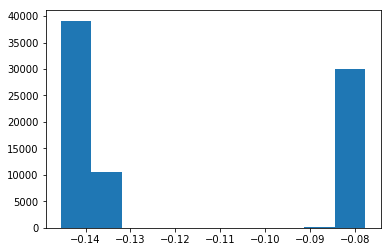

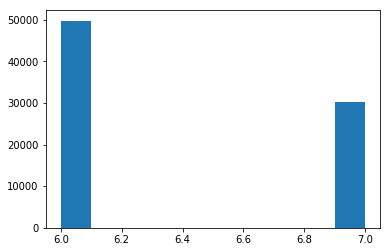

In [18]:
sTime = time.time()
efficiency_gaps, wins = run_simple(graph, 80000)
print('{}s'.format(time.time() - sTime))
print(len(efficiency_gaps))
plt.hist(efficiency_gaps)
plt.show()
plt.hist(wins)
plt.show()

In [ ]:
chain = run_simple(graph, 500)
for p in chain:
    print(p.accepted)
    #print(dir(p))
    print(dir(p.graph))
    raise ValueError

In [ ]:
%reset